In [1]:
import os
import numpy as np
import matplotlib
import pandas as pd
import json
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import wandb

In [2]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Define all possible names and assign fixed colors
all_names = ["DoNothing", "Greedy", "PPO", "PPO*"]
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))

# Make baselines training curves

## Gather data of baselines from WandB

In [330]:
project='Case14_SurveyPaperBase'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs = [run for run in runs if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperBase
Matching runs: 15
Found 15 runs with env_config.action_space='medha'


In [23]:
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        if (run.config.get('num_sgd_iter') == 15) and not run.config.get('opponent') : # Incorrect config.
            continue
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        metrics_df['name'] = "PPO*" if run.config.get('opponent') else "PPO"
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [335]:
df_base = make_df_metrics(filtered_runs)
df_base

grid2op_end_mean  mean_reconnect_count  mean_reset_count  \
0                 206              1.000000                 0   
1                 177              1.000000                 0   
2                 227              1.000000                 0   
3                 331              2.000000                 0   
4                 284              1.000000                 0   
..                ...                   ...               ...   
922              6713              0.000000                 0   
923              7458              0.000000                 0   
924              6812              0.000000                 0   
925              7065              0.005208                 0   
926              7153              0.004808                 0   

     mean_interact_count  corrected_ep_len_mean  grid2op_end_std  \
0               2.000000                    206     3.930591e+04   
1               2.000000                    177     4.104501e+04   
2               3.000000                    227     4.038289e+04   
3               3.000000                    331     5.663826e+04   
4               3.000000                    284     7.920459e+04   
..                   ...                    ...              ...   
922             7.062500                   6713     4.991212e+06   
923             4.128906                   7458     2.986585e+06   
924             5.489583                   6812     5.170838e+06   
925             5.588542                   7065     4.241171e+06   
926             5.115385                   7153     4.340316e+06   

     mean_active_dn_count  env_interactions  name  mean_disconnect_count  
0                0.000000              1115  PPO*                    NaN  
1                0.000000              2197  PPO*                    NaN  
2                0.000000              3281  PPO*                    NaN  
3                0.000000              4341  PPO*                    NaN  
4                0.000000              5381  PPO*                    NaN  
..                    ...               ...   ...                    ...  
922              1.943750             95609   PPO                    0.0  
923              1.054688             96666   PPO                    0.0  
924              1.286458             97720   PPO                    0.0  
925              1.208333             98793   PPO                    0.0  
926              1.115385             99857   PPO                    0.0  

[927 rows x 10 columns]

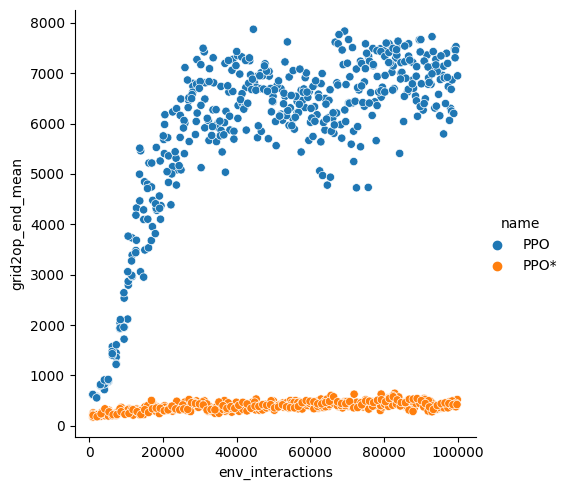

In [74]:
sns.relplot(x="env_interactions", y="grid2op_end_mean", hue="name", data=df)
plt.show()

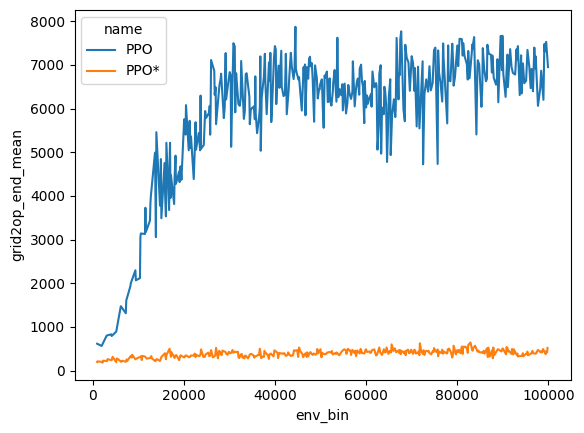

In [72]:
sns.lineplot(x="env_bin", y="grid2op_end_mean", hue="name", data=df_smoothed)
plt.show()

## make the plot

In [74]:
max_env_steps = 8064
# Define the bin width for grouping (adjust this based on your data range)
bin_width = 1500

def make_training_curve(df, header, max_env_steps=8064, bin_width=1500, palette=None, order=None, fig_width=8, fig_height=6, highvis=False, important_names=None):
    
    # Create bins for 'env_interactions'
    df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width
    
    # Aggregate data by bins and name
    aggregated = df.groupby(['env_bin', 'name']).agg({
        'grid2op_end_mean': ['mean', 'std'],  # Mean and standard deviation
        'env_interactions': 'mean'  # Bin center
    }).reset_index()
    
    # Flatten the MultiIndex columns
    aggregated.columns = ['env_bin', 'name', 'mean', 'std', 'env_interactions']
    
    # Style
    # Set up a color palette
    if palette is None:
        palette = sns.color_palette("hls",len(df.name.unique()))
    style = ['science', 'grid', 'no-latex']
    if highvis:
        style.append('high-vis')

    plt.style.use(style)
    # Size
    plt.figure(figsize=(fig_width, fig_height))
    ax = plt.gca()
    
    # Plot with Seaborn
    if important_names is None:
        sns.lineplot(
            x="env_interactions",
            y="mean",
            hue="name",
            data=aggregated,
            palette=palette,
            ax=ax,
            style='name' if highvis else None,
            style_order=order,
            # linewidth=1.5,
            # size='name'
        )
        plt.legend(fontsize=14, bbox_to_anchor=(1, 1), loc='upper left')
    else:
        names = sorted(df['name'].unique())
        # print(names)
        line_widths = [2.0 if name in important_names else 1.0 for name in names] # Thicker for important lines
        dashes = ['' if name in important_names else (3, 2) for name in names]
        # print(dashes)
        # line_alphas = [1.0 if name in important_names else 0.7 for name in names] # More visible for important lines
        sns.lineplot(
            x="env_interactions",
            y="mean",
            hue="name",
            data=aggregated,
            palette=palette,
            ax=ax,
            size='name',
            sizes=line_widths,
            style='name', # if highvis else None,
            dashes=dashes, # [(3, 2) for name in names], # does not work
            # alpha=line_alphas, # does not work
        )
        handles, labels = ax.get_legend_handles_labels()
        # print(labels)
        [handle.set_linewidth(width) for handle,width in zip(handles, line_widths)]
        plt.legend(handles=handles, labels=labels, fontsize=14, bbox_to_anchor=(1, 1), loc='upper left')

    # Add the shaded area for std
    for i, (name, group) in enumerate(aggregated.groupby('name')):
        plt.fill_between(
            group['env_interactions'],
            group['mean'] - group['std'],
            group['mean'] + group['std'],
            alpha=0.1 if (important_names is None) or (name in important_names) else 0.07,  # Subtle shading for non-important lines
            color=palette[name]
        )
            
    
    plt.title(label=header, fontsize=20, fontweight="bold")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.ylim(ymin=0, ymax=max_env_steps+100)
    # plt.xlim(xmin=0, xmax=100_000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Environment interactions', fontsize=16)
    plt.ylabel('Time steps survived', fontsize=16)
      # Match the linewidth of the plot
    # plt.legend(handles=handles, labels=labels, fontsize=14, bbox_to_anchor=(1, 1), loc='upper left')
    return plt

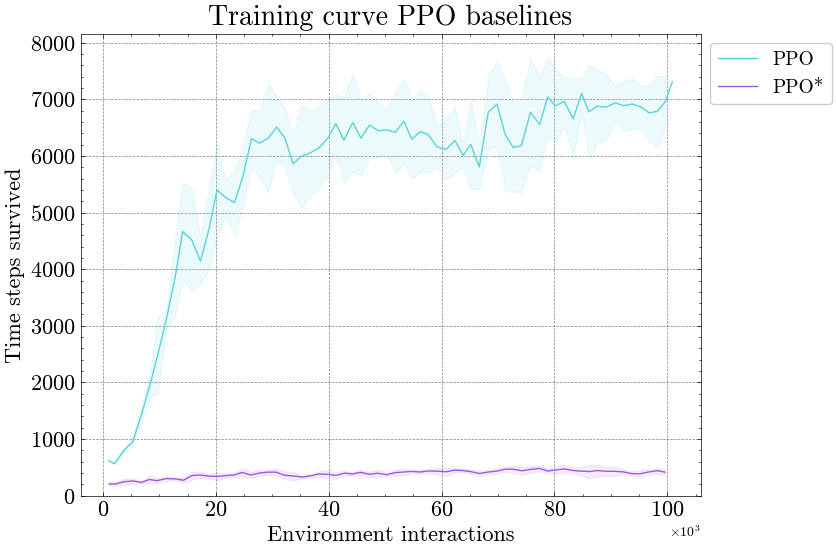

In [336]:
# Define all possible names and assign fixed colors
all_names = ["DoNothing", "Greedy", "PPO", "PPO*"]
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))
plt = make_training_curve(df_base, header="Training curve PPO baselines", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents_New.svg'))

In [332]:
project='Case14_Opponent'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs_opp = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs_opp)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs_opp = [run for run in runs_opp if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs_opp)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_Opponent
Matching runs: 10
Found 5 runs with env_config.action_space='medha'


In [138]:
df_opp = make_df_metrics(filtered_runs_opp)
df_opp

mean_reconnect_count  mean_interact_count  grid2op_end_std  \
0                        1                    2     37271.248748   
1                        1                    2     55624.774760   
2                        1                    2     68550.918208   
3                        2                    3     64223.592683   
4                        1                    3     63268.001084   
...                    ...                  ...              ...   
2322                     3                    4     85384.910593   
2323                     2                    4     94762.342045   
2324                     3                    4    108076.683541   
2325                     3                    4    106595.149954   
2326                     2                    4     91234.808961   

      mean_active_dn_count  grid2op_end_mean  corrected_ep_len_mean  \
0                        0               173                    173   
1                        0               226                    226   
2                        0               262                    262   
3                        0               315                    315   
4                        0               271                    271   
...                    ...               ...                    ...   
2322                     0               459                    459   
2323                     1               407                    407   
2324                     0               450                    450   
2325                     0               449                    449   
2326                     1               426                    426   

      mean_reset_count  env_interactions  name  
0                    0              1137  PPO*  
1                    0              2311  PPO*  
2                    0              3398  PPO*  
3                    0              4454  PPO*  
4                    0              5534  PPO*  
...                ...               ...   ...  
2322                 0            494872  PPO*  
2323                 0            495905  PPO*  
2324                 0            496957  PPO*  
2325                 0            498040  PPO*  
2326                 0            499147  PPO*  

[2327 rows x 9 columns]

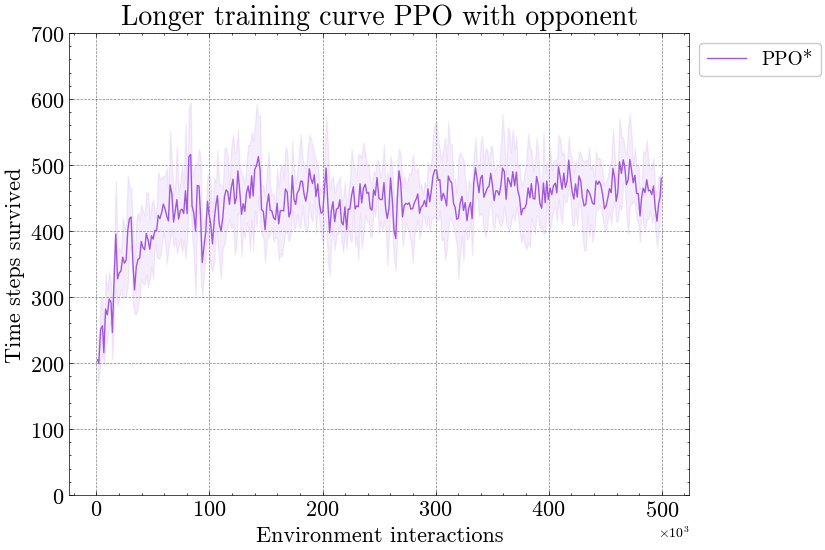

In [165]:
plt = make_training_curve(df_opp, header="Longer training curve PPO with opponent", max_env_steps=600, palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents_OppLong.svg'))

In [5]:
def make_color_dict(all_names, baseline_name, base_color = (0.33999999999999997, 0.8287999999999999, 0.86)):
    pos_base = np.nonzero(all_names==baseline_name)[0][0]
    palette = sns.color_palette("hls", len(all_names))
    if (0.33999999999999997, 0.8287999999999999, 0.86) in palette:
        color_pos = palette.index(base_color)
    else:
        color_pos = len(all_names)-1
        palette[color_pos] = (0.33999999999999997, 0.8287999999999999, 0.86)
    order_names = np.roll(all_names, color_pos-pos_base)
    ordered_palette = dict(zip(order_names, palette))
    return ordered_palette

In [15]:
project='Case14_SurveyPaperBase_Opp'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperBase_Opp
Matching runs: 5


In [24]:
df_opp = make_df_metrics(runs)
df_opp

mean_interact_count  corrected_ep_len_mean  mean_active_dn_count  \
0                2.679245                    173              0.122642   
1                3.074627                    249              0.182090   
2                2.765789                    219              0.221053   
3                3.065903                    301              0.180516   
4                3.411765                    293              0.241486   
...                   ...                    ...                   ...   
2327             4.447154                    454              0.800813   
2328             4.117647                    435              0.632353   
2329             4.555102                    422              0.575510   
2330             5.013333                    455              0.951111   
2331             5.868020                    512              2.776650   

      mean_disconnect_count  grid2op_end_std  mean_reconnect_count  \
0                         0     37270.564786              1.193396   
1                         0     55426.067864              1.749254   
2                         0     61768.579363              1.513158   
3                         0     74134.948679              2.097421   
4                         0     63261.095688              2.012384   
...                     ...              ...                   ...   
2327                      0     74817.487540              2.991870   
2328                      0    110540.964046              2.882353   
2329                      0    131120.744123              2.816327   
2330                      0    100238.669551              3.088889   
2331                      0    168207.548868              3.527919   

      mean_reset_count  grid2op_end_mean  env_interactions  name  
0                    0               173              1136  PPO*  
1                    0               249              2166  PPO*  
2                    0               219              3217  PPO*  
3                    0               301              4287  PPO*  
4                    0               293              5389  PPO*  
...                ...               ...               ...   ...  
2327                 0               454            494462  PPO*  
2328                 0               435            495582  PPO*  
2329                 0               422            496698  PPO*  
2330                 0               455            497826  PPO*  
2331                 0               512            498982  PPO*  

[2332 rows x 10 columns]

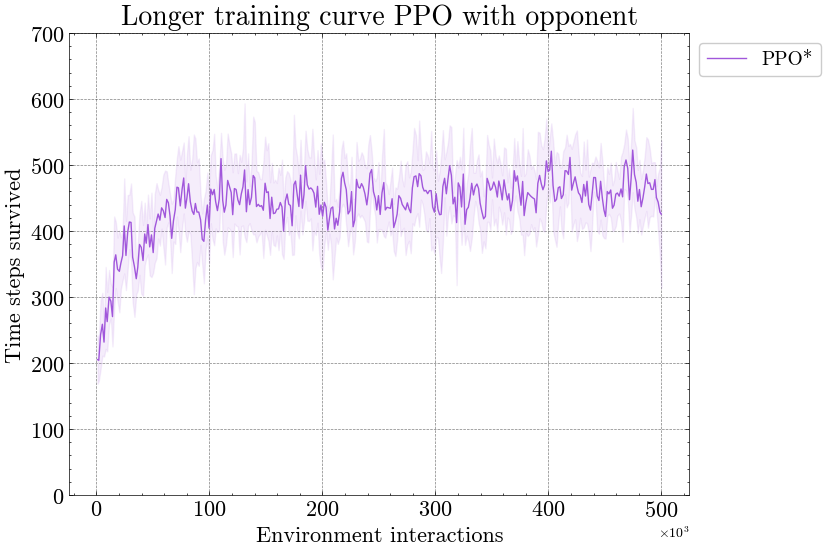

In [25]:
plt = make_training_curve(df_opp, header="Longer training curve PPO with opponent", max_env_steps=600, palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents_OppLong1.svg'))

# Action spaces experiments

In [143]:
project='Case14_SurvPapAct'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs = [run for run in runs if run.config.get("env_config", {}).get("action_space") in ["assym", "medha", "tennet", "d3qn2022"]]

print(f"Found {len(filtered_runs)} runs satisfying condition")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurvPapAct
Matching runs: 60
Found 55 runs satisfying condition


In [144]:
# Adjust function to include action space information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = PPO(*) + action_space
        if run.config.get("env_config", {}).get("action_space") == "assym":
            action_space = "$\mathcal{A}_{sym}$"  
        elif run.config.get("env_config", {}).get("action_space") == "medha":
            action_space = "$\mathcal{A}_{n-0}$"  
        elif run.config.get("env_config", {}).get("action_space") == "tennet":
            action_space = "$\mathcal{A}_{n-1}$"
        elif run.config.get("env_config", {}).get("action_space") == "d3qn2022":
            action_space = "$\mathcal{A}_{d3qn}$"  
        else:
            action_space = ""
        metrics_df['name'] = action_space
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [145]:
runs_NoOpp = [run for run in runs if not run.config.get('opponent')]
df_act = make_df_metrics(runs_NoOpp)
df_act

mean_reset_count  mean_reconnect_count  grid2op_end_std  \
0                    0              0.000000     5.129453e+04   
1                    0              0.000000     4.512383e+04   
2                    0              0.000000     5.890376e+05   
3                    0              0.000000     9.543076e+04   
4                    0              0.000000     3.642673e+05   
...                ...                   ...              ...   
3404                 0              0.008299     4.985589e+06   
3405                 0              0.000000     5.084663e+06   
3406                 0              0.000000     2.867251e+06   
3407                 0              0.000000     2.097858e+06   
3408                 0              0.000000     1.731448e+06   

      grid2op_end_mean  corrected_ep_len_mean  mean_active_dn_count  \
0                  605                    605              0.000000   
1                  604                    604              0.000000   
2                  785                    785              0.000000   
3                  653                    653              0.000000   
4                  825                    825              0.000000   
...                ...                    ...                   ...   
3404              6723                   6723              0.419087   
3405              6716                   6716              0.450000   
3406              7349                   7349              0.640000   
3407              7579                   7579              0.354167   
3408              7526                   7526              0.327206   

      mean_interact_count  env_interactions                 name  \
0                3.000000              1063  $\mathcal{A}_{n-1}$   
1                3.000000              2128  $\mathcal{A}_{n-1}$   
2                4.000000              3176  $\mathcal{A}_{n-1}$   
3                4.000000              4232  $\mathcal{A}_{n-1}$   
4                5.000000              5281  $\mathcal{A}_{n-1}$   
...                   ...               ...                  ...   
3404             4.377593             95176  $\mathcal{A}_{sym}$   
3405             4.483333             96252  $\mathcal{A}_{sym}$   
3406             4.631111             97294  $\mathcal{A}_{sym}$   
3407             3.760417             98377  $\mathcal{A}_{sym}$   
3408             3.948529             99451  $\mathcal{A}_{sym}$   

      mean_disconnect_count  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
3404                    0.0  
3405                    0.0  
3406                    0.0  
3407                    0.0  
3408                    0.0  

[3409 rows x 10 columns]

In [344]:
df_act['name'].unique()

array(['$\\mathcal{A}_{n-1}$', '$\\mathcal{A}_{sym}$',
       '$\\mathcal{A}_{d3qn}$', '', '$\\mathcal{A}_{n-0}$'], dtype=object)

In [345]:
df_act = df_act[df_act['name']!=""]
df_act['name'].unique()

array(['$\\mathcal{A}_{n-1}$', '$\\mathcal{A}_{sym}$',
       '$\\mathcal{A}_{d3qn}$', '$\\mathcal{A}_{n-0}$'], dtype=object)

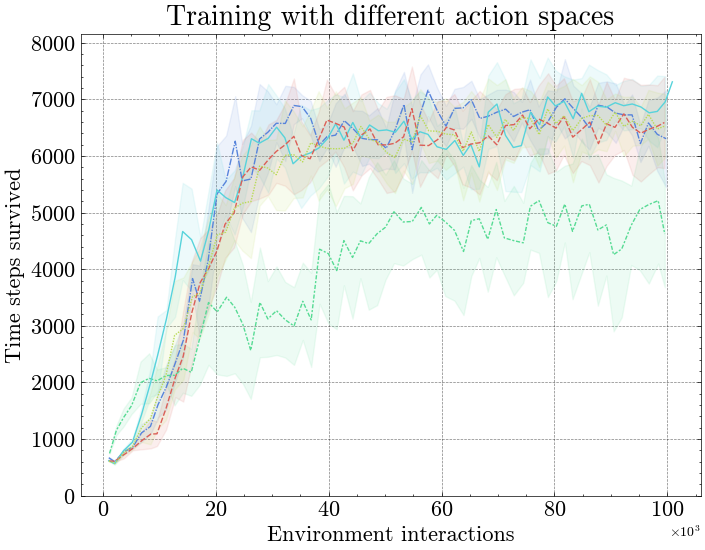

In [209]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_act['name'].unique()
baseline_name='$\\mathcal{A}_{n-0}$'
fixed_palette = make_color_dict(all_names, baseline_name=baseline_name)
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)

# plot 
plt = make_training_curve(df_act, 
                          header="Training with different action spaces", 
                          palette=fixed_palette,
                          highvis=True,
                          order=order,
                         )

#plot without legend
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path, f'Traincurve_ActSpaces.svg'))

In [149]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_act_opp = make_df_metrics(runs_Opp)
df_act_opp

corrected_ep_len_mean  mean_interact_count  grid2op_end_std  \
0                       220             3.000000     43835.147345   
1                       169             3.000000     37010.012030   
2                       223             3.000000     41197.150496   
3                       288             3.000000     59741.943024   
4                       354             3.000000     57780.361636   
...                     ...                  ...              ...   
1794                    342             4.850877    112260.412896   
1795                    382             5.172249    112864.741604   
1796                    461             5.107981    149080.428398   
1797                    489             5.104478    166429.633821   
1798                    507             5.793296    163954.581817   

      mean_active_dn_count  mean_reset_count  grid2op_end_mean  \
0                 0.000000                 0               220   
1                 0.000000                 0               169   
2                 0.000000                 0               223   
3                 0.000000                 0               288   
4                 0.000000                 0               354   
...                    ...               ...               ...   
1794              1.508772                 0               342   
1795              1.311005                 0               382   
1796              1.323944                 0               461   
1797              1.298507                 0               489   
1798              1.586592                 0               507   

      mean_reconnect_count  env_interactions                 name  \
0                 1.000000              1142  $\mathcal{A}_{n-1}$   
1                 1.000000              2185  $\mathcal{A}_{n-1}$   
2                 1.000000              3301  $\mathcal{A}_{n-1}$   
3                 2.000000              4408  $\mathcal{A}_{n-1}$   
4                 2.000000              5493  $\mathcal{A}_{n-1}$   
...                    ...               ...                  ...   
1794              2.307018             95683  $\mathcal{A}_{n-0}$   
1795              2.550239             96764  $\mathcal{A}_{n-0}$   
1796              3.117371             97852  $\mathcal{A}_{n-0}$   
1797              3.194030             98878  $\mathcal{A}_{n-0}$   
1798              3.256983             99915  $\mathcal{A}_{n-0}$   

      mean_disconnect_count  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
1794                    0.0  
1795                    0.0  
1796                    0.0  
1797                    0.0  
1798                    0.0  

[1799 rows x 10 columns]

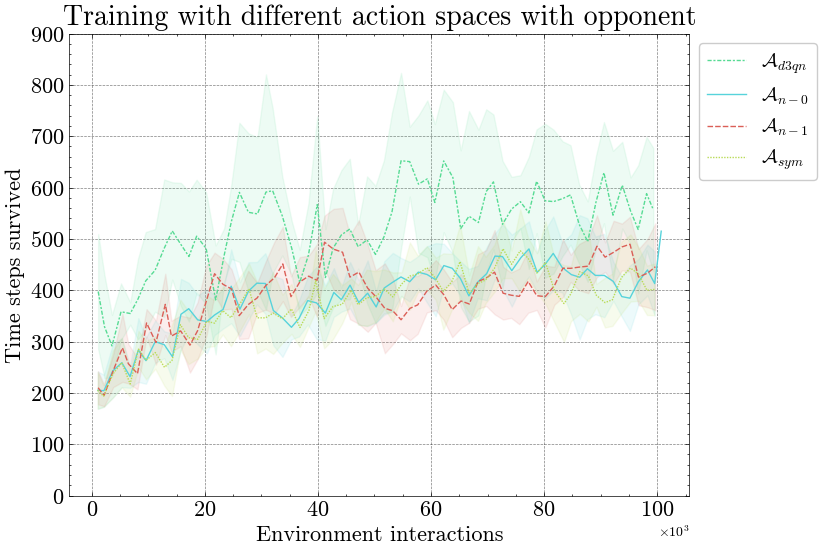

In [150]:
# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_training_curve(df_act_opp, 
                          header="Training with different action spaces with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=800,
                          highvis=True,
                          order=order,
                         )
plt.savefig(os.path.join(path, f'Traincurve_ActSpaces_Opp.svg'))

# Observation spaces experiments

In [151]:
project='Case14_SurveyPaperObs'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperObs
Matching runs: 70


In [152]:
# Adjust function to include observation space information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = observation_space
        if run.config.get("env_config", {}).get("g2op_input") == "all":
            obs_space = "Complete"   
        elif run.config.get("env_config", {}).get("g2op_input") == ["r"] or run.config.get("env_config", {}).get("g2op_input") == "r":
            obs_space = "Line loads"   
        elif run.config.get("env_config", {}).get("n_history") == 6:
            obs_space = "History" 
        elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
            obs_space = "Danger"
        elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "Baseline" 
        elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "D3QN_2022" 
        else:
            obs_space = ""
        metrics_df['name'] = obs_space
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [153]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
print(f"Matching runs: {len(runs_NoOpp)}")

Matching runs: 30


In [154]:
df_obs = make_df_metrics(runs_NoOpp)
df_obs

mean_interact_count  grid2op_end_std  mean_reset_count  \
0                2.917614     4.892728e+04                 0   
1                2.972452     2.356962e+05                 0   
2                3.062500     3.257949e+05                 0   
3                3.559211     5.922907e+05                 0   
4                4.218750     1.357251e+06                 0   
...                   ...              ...               ...   
2756             4.062257     5.885340e+06                 0   
2757             3.927007     7.093824e+06                 0   
2758             3.614583     6.513658e+06                 0   
2759             3.611111     2.740482e+06                 0   
2760             3.729167     5.906270e+06                 0   

      mean_active_dn_count  grid2op_end_mean  mean_reconnect_count  \
0                 0.173295               614              0.000000   
1                 0.181818               590              0.013774   
2                 0.273810               804              0.000000   
3                 0.296053               800              0.000000   
4                 0.476562              1024              0.015625   
...                    ...               ...                   ...   
2756              0.513619              6710              0.000000   
2757              0.430657              6212              0.000000   
2758              0.302083              6514              0.000000   
2759              0.381944              7410              0.000000   
2760              0.267361              6630              0.000000   

      corrected_ep_len_mean  mean_disconnect_count  env_interactions      name  
0                       614                      0              1027  Baseline  
1                       590                      0              2106  Baseline  
2                       804                      0              3135  Baseline  
3                       800                      0              4217  Baseline  
4                      1024                      0              5297  Baseline  
...                     ...                    ...               ...       ...  
2756                   6710                      0             95522    Danger  
2757                   6212                      0             96598    Danger  
2758                   6514                      0             97639    Danger  
2759                   7410                      0             98679    Danger  
2760                   6630                      0             99753    Danger  

[2761 rows x 10 columns]

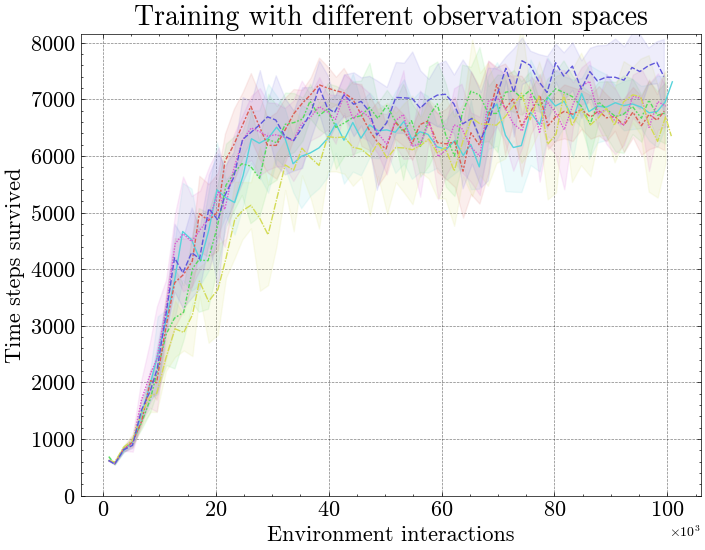

In [208]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_obs['name'].unique()
baseline_name='Baseline'
fixed_palette = make_color_dict(all_names, baseline_name=baseline_name)
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)

# plot 
plt = make_training_curve(df_obs, 
                          header="Training with different observation spaces", 
                          palette=fixed_palette,
                          highvis=True,
                          order=order,
                         )
#plot without legend
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path, f'Traincurve_ObsSpaces.svg'))

In [158]:
project='OBS_OPPONENT'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/OBS_OPPONENT
Matching runs: 30


In [159]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_obs_opp = make_df_metrics(runs_Opp)
df_obs_opp

corrected_ep_len_mean  mean_reconnect_count  mean_reset_count  \
0                       210              1.000000                 0   
1                       167              1.000000                 0   
2                       223              1.000000                 0   
3                       308              2.000000                 0   
4                       286              1.000000                 0   
...                     ...                   ...               ...   
2783                    342              2.307018                 0   
2784                    382              2.550239                 0   
2785                    461              3.117371                 0   
2786                    489              3.194030                 0   
2787                    507              3.256983                 0   

      grid2op_end_std  grid2op_end_mean  mean_interact_count  \
0        41132.106698               210             2.000000   
1        37928.364291               167             2.000000   
2        38053.788611               223             3.000000   
3        56082.314019               308             3.000000   
4        71105.371396               286             3.000000   
...               ...               ...                  ...   
2783    112260.412896               342             4.850877   
2784    112864.741604               382             5.172249   
2785    149080.428398               461             5.107981   
2786    166429.633821               489             5.104478   
2787    163954.581817               507             5.793296   

      mean_active_dn_count  env_interactions      name  mean_disconnect_count  
0                 0.000000              1074    Danger                    NaN  
1                 0.000000              2102    Danger                    NaN  
2                 0.000000              3170    Danger                    NaN  
3                 0.000000              4217    Danger                    NaN  
4                 0.000000              5308    Danger                    NaN  
...                    ...               ...       ...                    ...  
2783              1.508772             95683  Baseline                    0.0  
2784              1.311005             96764  Baseline                    0.0  
2785              1.323944             97852  Baseline                    0.0  
2786              1.298507             98878  Baseline                    0.0  
2787              1.586592             99915  Baseline                    0.0  

[2788 rows x 10 columns]

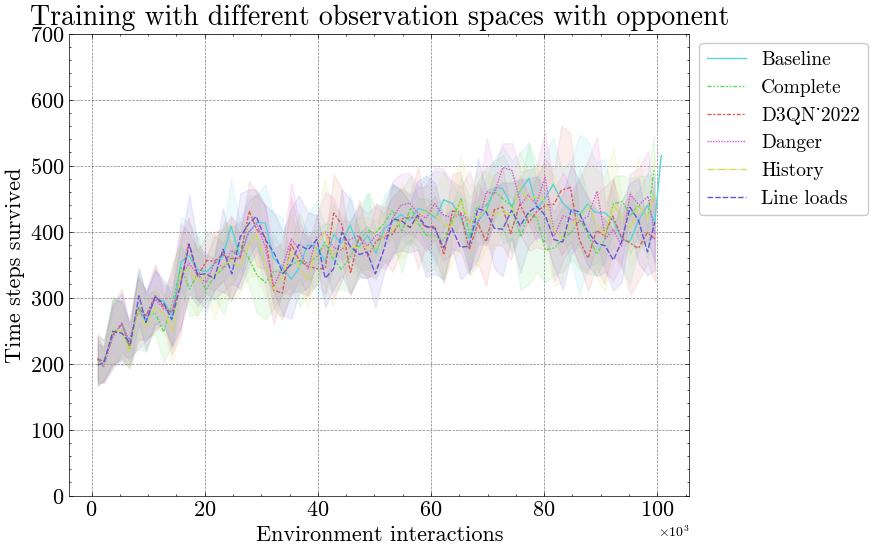

In [160]:
# Use LateX notations.
plt.rcParams['text.usetex'] = True
# plot 
plt = make_training_curve(df_obs_opp, 
                          header="Training with different observation spaces with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=600,
                          highvis=True,
                          order=order
                         )
plt.savefig(os.path.join(path, f'Traincurve_ObsSpacesOpp.svg'))

In [143]:
agent_obs_spaces = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    # Set name = observation_space
    if run.config.get("env_config", {}).get("g2op_input") == "all":
        obs_space = "Complete"
    elif run.config.get("env_config", {}).get("g2op_input") == ["r"] or run.config.get("env_config", {}).get("g2op_input") == "r":
        obs_space = "Line loads"
    elif run.config.get("env_config", {}).get("n_history") == 6:
        obs_space = "History"
    elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
        obs_space = "Danger"
    elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
        obs_space = "Baseline"
    elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
        obs_space = "D3QN_2022"
    else:
        obs_space = ""
    data["observation space"] = obs_space
    agent_obs_spaces.append(data)

df_agent_obs_spaces = pd.DataFrame(agent_obs_spaces)
# df_agent_obs_spaces =df_agent_obs_spaces.sort_values(['observation space'], ascending=[True])
df_agent_obs_spaces.to_csv(os.path.join(path, "Obs_spaces_agent_ids.csv"), index=False)
df_agent_obs_spaces

agent_id observation space
0   CustomPPO_old_env_9405393_5e732            Danger
1   CustomPPO_old_env_9405344_a7981        Line loads
2   CustomPPO_old_env_9405597_65585          Complete
3   CustomPPO_old_env_9405342_ab255        Line loads
4   CustomPPO_old_env_9405346_ab0a9        Line loads
..                              ...               ...
85  CustomPPO_old_env_9398580_7cbcd          Baseline
86  CustomPPO_old_env_9398576_7a291          Baseline
87  CustomPPO_old_env_9404845_381cb          Baseline
88  CustomPPO_old_env_9398579_742a5          Baseline
89  CustomPPO_old_env_9398578_766ba          Baseline

[90 rows x 2 columns]

# Reward experiments

In [223]:
project='Case14_SurveyPaperRw'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperRw
Matching runs: 85


In [225]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        ep_rw = metrics_df['episode_reward_mean']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df['episode_reward'] = ep_rw
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = reward function
        # print(run.config.get("reward_fun", ""))
        if run.config.get("reward_fun", "") == "ScaledL2RPNReward":
            if run.config.get("env_config", {}).get("reward_finish"):
                rw_fun = "Base + Bonus/Penalty"
            else:
                rw_fun = "Baseline"   
        elif run.config.get("reward_fun", "") == "AlphaZeroRW":
            rw_fun = "AlphaZero" 
        elif run.config.get("reward_fun", "") == "RewardRho":
            rw_fun = "Binbinchen"
        elif run.config.get("reward_fun", "") == "LossReward":
            rw_fun = "SMAAC"
        elif run.config.get("reward_fun", "") == "ConstantReward":
            rw_fun = "Constant"            
        else:
            print("This reward function is not defined:", run.config.get("reward_fun", ""))
            rw_fun = ""
        metrics_df['name'] = rw_fun
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [226]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
print(f"Matching runs: {len(runs_NoOpp)}")

Matching runs: 30


In [227]:
df_rw = make_df_metrics(runs_NoOpp)
df_rw

mean_interact_count  grid2op_end_std  mean_reset_count  \
0                2.917614     4.892728e+04                 0   
1                2.972452     2.356962e+05                 0   
2                3.062500     3.257949e+05                 0   
3                3.559211     5.922907e+05                 0   
4                4.218750     1.357251e+06                 0   
...                   ...              ...               ...   
2752             3.801471     5.996056e+06                 0   
2753             3.631579     2.491814e+06                 0   
2754             3.516447     4.612751e+06                 0   
2755             4.179688     2.594192e+06                 0   
2756             6.005682     6.100692e+06                 0   

      mean_active_dn_count  grid2op_end_mean  mean_reconnect_count  \
0                 0.173295               614              0.000000   
1                 0.181818               590              0.013774   
2                 0.273810               804              0.000000   
3                 0.296053               800              0.000000   
4                 0.476562              1024              0.015625   
...                    ...               ...                   ...   
2752              0.327206              6670              0.000000   
2753              0.355263              7531              0.000000   
2754              0.361842              7117              0.000000   
2755              0.476562              7110              0.000000   
2756              1.744318              5890              0.000000   

      corrected_ep_len_mean  mean_disconnect_count  env_interactions  \
0                       614                      0              1027   
1                       590                      0              2106   
2                       804                      0              3135   
3                       800                      0              4217   
4                      1024                      0              5297   
...                     ...                    ...               ...   
2752                   6670                      0             95507   
2753                   7531                      0             96611   
2754                   7117                      0             97680   
2755                   7110                      0             98750   
2756                   5890                      0             99807   

      episode_reward       name  
0          24.157239   Baseline  
1          53.378621   Baseline  
2          40.536567   Baseline  
3         124.108137   Baseline  
4         277.079375   Baseline  
...              ...        ...  
2752     4800.689259  AlphaZero  
2753     5412.192783  AlphaZero  
2754     5043.672132  AlphaZero  
2755     5006.640463  AlphaZero  
2756     4115.553020  AlphaZero  

[2757 rows x 11 columns]

In [261]:
df_rw.columns

Index(['mean_interact_count', 'grid2op_end_std', 'mean_reset_count',
       'mean_active_dn_count', 'grid2op_end_mean', 'mean_reconnect_count',
       'corrected_ep_len_mean', 'mean_disconnect_count', 'env_interactions',
       'episode_reward', 'name'],
      dtype='object')

In [166]:
df_rw['name'].unique()

array(['Baseline', 'Binbinchen', 'Base + Bonus/Penalty', 'Constant',
       'AlphaZero', 'SMAAC'], dtype=object)

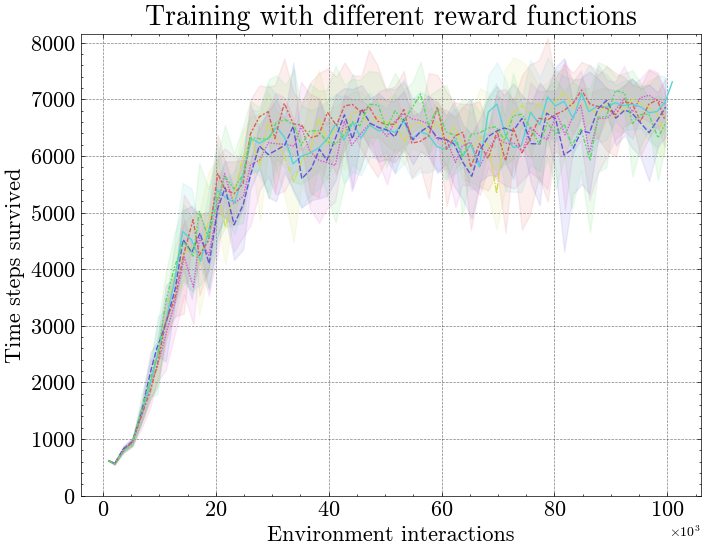

In [228]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_rw['name'].unique()
baseline_name='Baseline'
fixed_palette = make_color_dict(all_names, baseline_name=baseline_name)
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)

# plot 
plt = make_training_curve(df_rw, 
                          header="Training with different reward functions", 
                          palette=fixed_palette,
                          highvis=True,
                          order=order
                         )
#plot without legend
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path, f'Traincurve_RW.svg'))

In [171]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
print(f"Matching runs: {len(runs_Opp)}")

Matching runs: 30


In [172]:
df_rw_opp = make_df_metrics(runs_Opp)
df_rw_opp

mean_interact_count  mean_reconnect_count  corrected_ep_len_mean  \
0                2.000000              1.000000                    173   
1                3.000000              1.000000                    256   
2                2.000000              1.000000                    223   
3                3.000000              2.000000                    312   
4                3.000000              2.000000                    298   
...                   ...                   ...                    ...   
2767             4.850877              2.307018                    342   
2768             5.172249              2.550239                    382   
2769             5.107981              3.117371                    461   
2770             5.104478              3.194030                    489   
2771             5.793296              3.256983                    507   

      mean_reset_count  mean_active_dn_count  grid2op_end_mean  \
0                    0              0.000000               173   
1                    0              0.000000               256   
2                    0              0.000000               223   
3                    0              0.000000               312   
4                    0              0.000000               298   
...                ...                   ...               ...   
2767                 0              1.508772               342   
2768                 0              1.311005               382   
2769                 0              1.323944               461   
2770                 0              1.298507               489   
2771                 0              1.586592               507   

      grid2op_end_std  env_interactions  episode_reward                  name  \
0        37270.564786              1136     -283.159962  Base + Bonus/Penalty   
1        60071.955551              2182     -281.366531  Base + Bonus/Penalty   
2        61772.160211              3225     -284.548375  Base + Bonus/Penalty   
3        77078.688005              4309     -260.538622  Base + Bonus/Penalty   
4        57432.774790              5400     -273.001256  Base + Bonus/Penalty   
...               ...               ...             ...                   ...   
2767    112260.412896             95683      207.076651              Baseline   
2768    112864.741604             96764      207.549857              Baseline   
2769    149080.428398             97852      196.703568              Baseline   
2770    166429.633821             98878      221.868427              Baseline   
2771    163954.581817             99915      249.958289              Baseline   

      mean_disconnect_count  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
2767                    0.0  
2768                    0.0  
2769                    0.0  
2770                    0.0  
2771                    0.0  

[2772 rows x 11 columns]

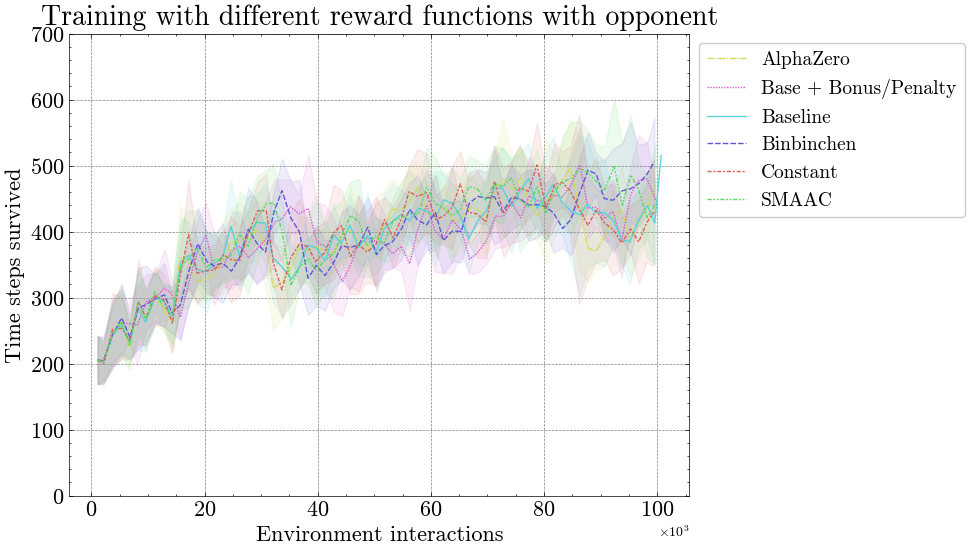

In [173]:
# plot 
plt = make_training_curve(df_rw_opp, 
                          header="Training with different reward functions with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=600,
                          highvis=True,
                          order=order
                         )
plt.savefig(os.path.join(path, f'Traincurve_RwOpp.svg'))

In [174]:
max_env_steps = 8064
# Define the bin width for grouping (adjust this based on your data range)
bin_width = 1500

def make_reward_curve(df, header, max_env_steps=8064, bin_width=1500, palette=None, highvis=False, order=None):
    
    # Create bins for 'env_interactions'
    df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width
    
    # Aggregate data by bins and name
    aggregated = df.groupby(['env_bin', 'name']).agg({
        'episode_reward': ['mean', 'std'],  # Mean and standard deviation
        'env_interactions': 'mean'  # Bin center
    }).reset_index()
    
    # Flatten the MultiIndex columns
    aggregated.columns = ['env_bin', 'name', 'mean', 'std', 'env_interactions']
    
    # Style
    # Set up a color palette
    if palette is None:
        palette = sns.color_palette("hls",len(df.name.unique()))
    style = ['science', 'grid', 'no-latex']
    if highvis:
        style.append('high-vis')
    plt.style.use(style)
    # Size
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Plot with Seaborn
    sns.lineplot(
        x="env_interactions",
        y="mean",
        hue="name",
        data=aggregated,
        palette=palette,
        ax=ax,
        style='name' if highvis else None,
        style_order=order,
        # marker="o",
    )
    
    # Add the shaded area for std
    for i, (name, group) in enumerate(aggregated.groupby('name')):
        plt.fill_between(
            group['env_interactions'],
            group['mean'] - group['std'],
            group['mean'] + group['std'],
            alpha=0.1,
            color=palette[name]
        )
    plt.title(label=header, fontsize=20, fontweight="bold")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.legend(fontsize=14)
    # plt.ylim(ymin=0, ymax=max_env_steps+100)
    # plt.xlim(xmin=0, xmax=100_000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Environment interactions', fontsize=16)
    plt.ylabel('Episode reward', fontsize=16)
    plt.legend(fontsize=14, bbox_to_anchor=(1, 1),
        loc='upper left') #, title="Agents",title_fontsize=16)
    return plt

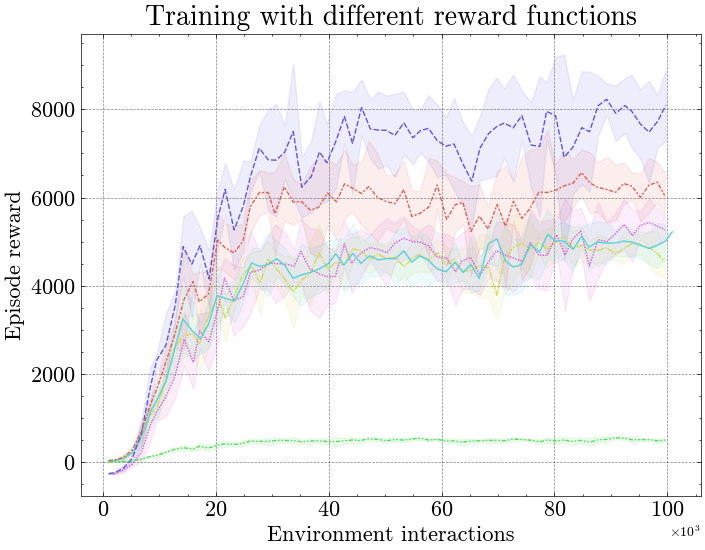

In [229]:
# plot 
plt = make_reward_curve(df_rw, 
                        header="Training with different reward functions", 
                        palette=fixed_palette,
                        highvis=True,
                        order=order
                       )
#plot without legend
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path, f'RewardCurve_RW.svg'))

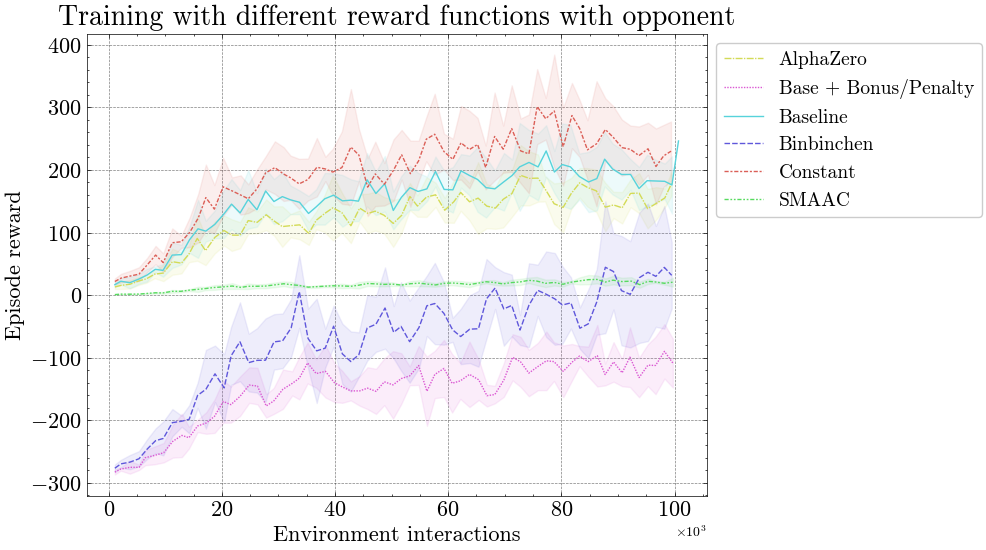

In [177]:
# plot 
plt = make_reward_curve(df_rw_opp, 
                        header="Training with different reward functions with opponent", 
                        palette=fixed_palette,
                        highvis=True,
                        order=order
                       )
plt.savefig(os.path.join(path, f'RewardCurve_RWOpp.svg'))

# Activation Threshold Experiments

In [131]:
project='Case14_SurveyPaperAT'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperAT
Matching runs: 55


In [217]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        time = metrics_df['time_total_s']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df['time_total_s'] = time
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = reward function
        metrics_df['name'] = "$\\rho_{\\text{act}}$: " + str(run.config.get("env_config", {}).get("rho_threshold"))
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [133]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_at = make_df_metrics(runs_NoOpp)
df_at

mean_interact_count  grid2op_end_std  mean_reset_count  \
0                2.917614     4.892728e+04                 0   
1                2.972452     2.356962e+05                 0   
2                3.062500     3.257949e+05                 0   
3                3.559211     5.922907e+05                 0   
4                4.218750     1.357251e+06                 0   
...                   ...              ...               ...   
1583             3.065476     7.063575e+05                 0   
1584             2.731771     3.018846e+05                 0   
1585             2.647500     2.485523e+05                 0   
1586             3.065476     3.163229e+05                 0   
1587             2.660000     4.830510e+04                 0   

      mean_active_dn_count  grid2op_end_mean  mean_reconnect_count  \
0                 0.173295               614              0.000000   
1                 0.181818               590              0.013774   
2                 0.273810               804              0.000000   
3                 0.296053               800              0.000000   
4                 0.476562              1024              0.015625   
...                    ...               ...                   ...   
1583              0.431548              7892              0.005952   
1584              0.299479              7954              0.000000   
1585              0.265000              7978              0.000000   
1586              0.398810              7987              0.017857   
1587              0.267500              8045              0.005000   

      corrected_ep_len_mean  mean_disconnect_count  env_interactions  \
0                       614                      0              1027   
1                       590                      0              2106   
2                       804                      0              3135   
3                       800                      0              4217   
4                      1024                      0              5297   
...                     ...                    ...               ...   
1583                   7892                      0             95347   
1584                   7954                      0             96396   
1585                   7978                      0             97455   
1586                   7987                      0             98485   
1587                   8045                      0             99549   

      time_total_s                       name  
0        60.827576  $\rho_{\text{act}}$: 0.95  
1       135.564684  $\rho_{\text{act}}$: 0.95  
2       247.741768  $\rho_{\text{act}}$: 0.95  
3       380.433806  $\rho_{\text{act}}$: 0.95  
4       551.488591  $\rho_{\text{act}}$: 0.95  
...            ...                        ...  
1583  39130.606221  $\rho_{\text{act}}$: 0.99  
1584  39697.579714  $\rho_{\text{act}}$: 0.99  
1585  40288.851166  $\rho_{\text{act}}$: 0.99  
1586  40788.005633  $\rho_{\text{act}}$: 0.99  
1587  41399.447663  $\rho_{\text{act}}$: 0.99  

[1588 rows x 11 columns]

In [46]:
df_at.name.unique()

array(['$\\rho_{\\text{act}}$: 0.95', '$\\rho_{\\text{act}}$: 0.8',
       '$\\rho_{\\text{act}}$: 0.9', '$\\rho_{\\text{act}}$: 0.99'],
      dtype=object)

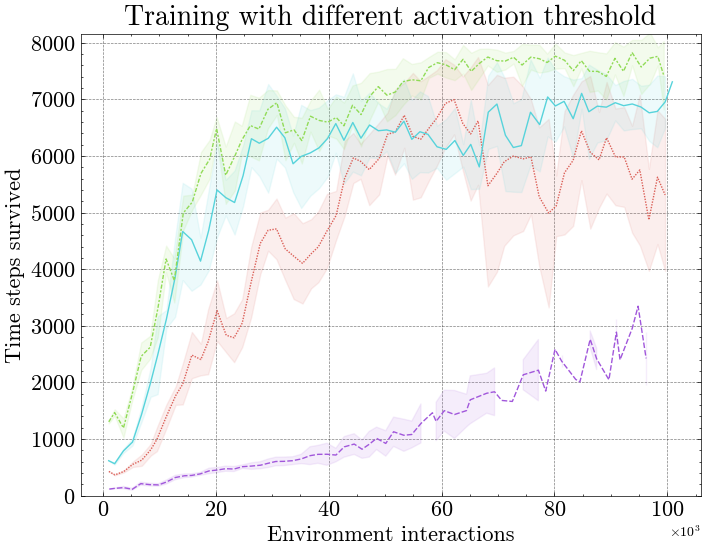

In [211]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_at['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='$\\rho_{\\text{act}}$: 0.95')
baseline_name='$\\rho_{\\text{act}}$: 0.95'
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)

# plot 
plt = make_training_curve(df_at, header="Training with different activation threshold", palette=fixed_palette, highvis=True, order=order)
#plot without legend
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path, f'Traincurve_AT.svg'))

In [80]:
baseline_name='$\\rho_{\\text{act}}$: 0.95'
pos = np.nonzero(np.sort(all_names)==baseline_name)[0][0]
np.roll(all_names, pos)

array(['$\\rho_{\\text{act}}$: 0.9', '$\\rho_{\\text{act}}$: 0.99',
       '$\\rho_{\\text{act}}$: 0.95', '$\\rho_{\\text{act}}$: 0.8'],
      dtype=object)

In [135]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_at_opp = make_df_metrics(runs_Opp)
df_at_opp

mean_interact_count  grid2op_end_mean  mean_reset_count  \
0                3.000000                 7                 0   
1                3.000000                 7                 0   
2                3.000000                20                 0   
3                3.000000                20                 0   
4                3.000000                22                 0   
...                   ...               ...               ...   
1833             4.850877               342                 0   
1834             5.172249               382                 0   
1835             5.107981               461                 0   
1836             5.104478               489                 0   
1837             5.793296               507                 0   

      grid2op_end_std  mean_reconnect_count  corrected_ep_len_mean  \
0          553.345724              0.000000                      7   
1          587.760919              0.000000                      7   
2         3287.667370              0.000000                     20   
3         2853.276707              0.000000                     20   
4         3385.795415              0.000000                     22   
...               ...                   ...                    ...   
1833    112260.412896              2.307018                    342   
1834    112864.741604              2.550239                    382   
1835    149080.428398              3.117371                    461   
1836    166429.633821              3.194030                    489   
1837    163954.581817              3.256983                    507   

      mean_active_dn_count  env_interactions  time_total_s  \
0                 0.000000              1227     10.807542   
1                 0.000000              2460     21.523601   
2                 0.000000              3516     31.044636   
3                 0.000000              4569     40.848347   
4                 0.000000              5617     49.412890   
...                    ...               ...           ...   
1833              1.508772             95683   5472.590400   
1834              1.311005             96764   5546.218743   
1835              1.323944             97852   5615.470136   
1836              1.298507             98878   5691.063213   
1837              1.586592             99915   5765.337725   

                           name  mean_disconnect_count  
0      $\rho_{\text{act}}$: 0.8                    NaN  
1      $\rho_{\text{act}}$: 0.8                    NaN  
2      $\rho_{\text{act}}$: 0.8                    NaN  
3      $\rho_{\text{act}}$: 0.8                    NaN  
4      $\rho_{\text{act}}$: 0.8                    NaN  
...                         ...                    ...  
1833  $\rho_{\text{act}}$: 0.95                    0.0  
1834  $\rho_{\text{act}}$: 0.95                    0.0  
1835  $\rho_{\text{act}}$: 0.95                    0.0  
1836  $\rho_{\text{act}}$: 0.95                    0.0  
1837  $\rho_{\text{act}}$: 0.95                    0.0  

[1838 rows x 11 columns]

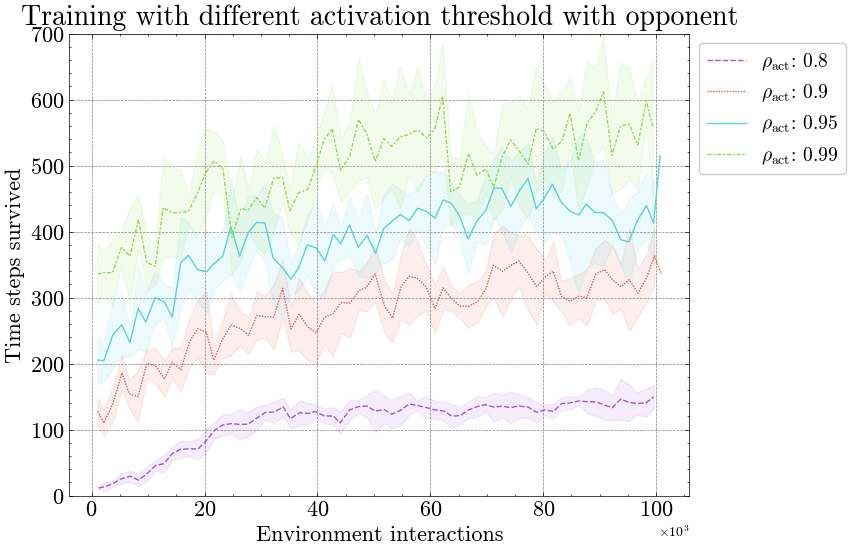

In [104]:
# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_training_curve(df_at_opp, 
                          header="Training with different activation threshold with opponent", 
                          palette=fixed_palette, 
                          highvis=True,
                          order=order, 
                          max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_AT_Opp.svg'))

## Longer training for each threshold

In [106]:
max_env_steps = 8064
# Define the bin width for grouping (adjust this based on your data range)
bin_width = 1500

def make_train_time_curve(df, header, max_env_steps=8064, bin_width=1500, palette=None, highvis=False, order=None):
    
    # Create bins for 'time_total_s'
    df['env_bin'] = (df['time_total_s'] // bin_width) * bin_width
    
    # Aggregate data by bins and name
    aggregated = df.groupby(['env_bin', 'name']).agg({
        'grid2op_end_mean': ['mean', 'std'],  # Mean and standard deviation
        'time_total_s': 'mean'  # Bin center
    }).reset_index()
    
    # Flatten the MultiIndex columns
    aggregated.columns = ['env_bin', 'name', 'mean', 'std', 'time_total_s']
    
    # Style
    # Set up a color palette
    if palette is None:
        palette = sns.color_palette("hls",len(df.name.unique()))
    style = ['science', 'grid', 'no-latex']
    if highvis:
        style.append('high-vis')
    plt.style.use(style)
    # Size
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Plot with Seaborn
    sns.lineplot(
        x="time_total_s",
        y="mean",
        hue="name",
        data=aggregated,
        palette=palette,
        ax=ax,
        style='name' if highvis else None,
        style_order=order,
        # marker="o",
    )
    
    # Add the shaded area for std
    for i, (name, group) in enumerate(aggregated.groupby('name')):
        plt.fill_between(
            group['time_total_s'],
            group['mean'] - group['std'],
            group['mean'] + group['std'],
            alpha=0.1,
            color=palette[name]
        )
    plt.title(label=header, fontsize=20, fontweight="bold")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.legend(fontsize=14)
    plt.ylim(ymin=0, ymax=max_env_steps+100)
    # plt.xlim(xmin=0, xmax=100_000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Duration in seconds', fontsize=16)
    plt.ylabel('Time steps survived', fontsize=16)
    plt.legend(fontsize=14, bbox_to_anchor=(1, 1),
        loc='upper left') #, title="Agents",title_fontsize=16)
    return plt

### short training shows

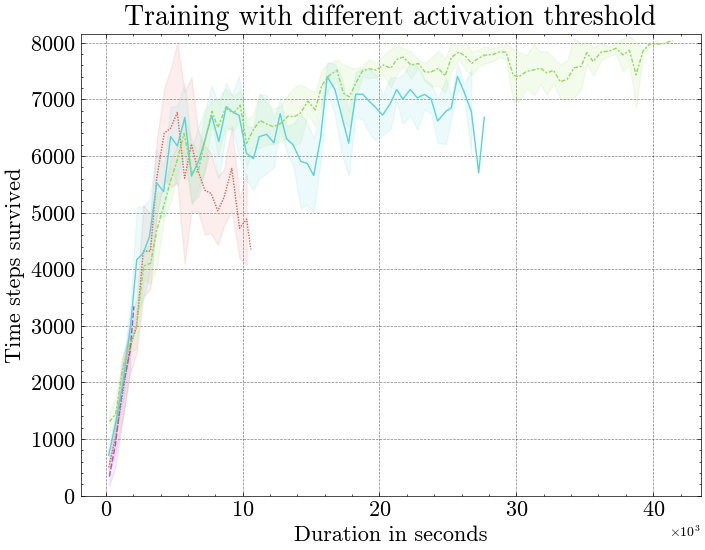

In [212]:
# plot 
plt = make_train_time_curve(df_at, 
                            header="Training with different activation threshold", 
                            palette=fixed_palette, 
                            highvis=True, 
                            order=order,
                            bin_width=500,
                           )
#plot without legend
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path, f'Traincurve_AT_time.svg'))

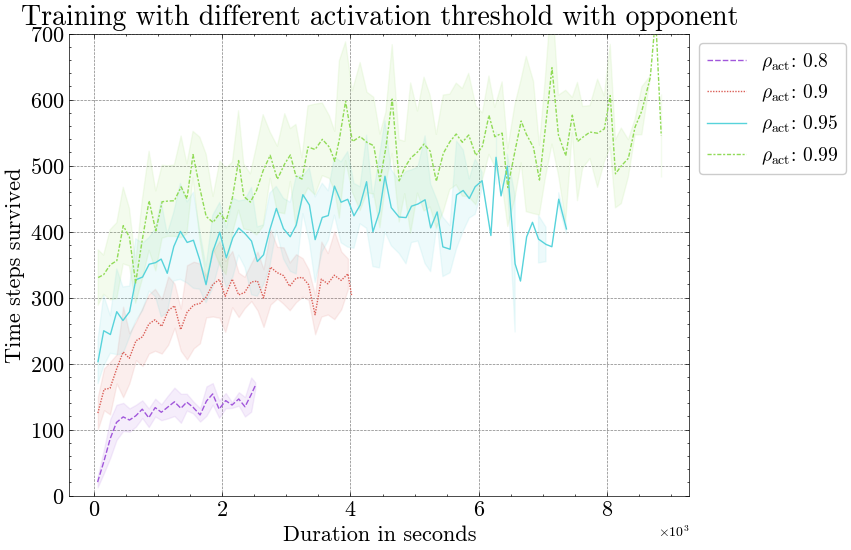

In [142]:
# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_train_time_curve(df_at_opp, 
                            header="Training with different activation threshold with opponent", 
                            palette=fixed_palette, 
                            max_env_steps=600,
                            highvis=True,
                            order=order,
                            bin_width=100,
                           )
plt.savefig(os.path.join(path, f'Traincurve_AT_Opp_time.svg'))

### LONG TRAINING

In [214]:
project='Case14_SurveyPaperATLong'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperATLong
Matching runs: 40


In [218]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_at_long = make_df_metrics(runs_NoOpp)
df_at_long

grid2op_end_mean  corrected_ep_len_mean  mean_reconnect_count  \
0                  122                    122              0.003247   
1                  152                    152              0.003676   
2                  234                    234              0.009709   
3                  380                    380              0.008475   
4                  357                    357              0.008696   
...                ...                    ...                   ...   
5277              7507                   7507              0.000000   
5278              7754                   7754              0.000000   
5279              7818                   7818              0.000000   
5280              7812                   7812              0.000000   
5281              7945                   7945              0.000000   

      mean_disconnect_count  mean_interact_count  mean_active_dn_count  \
0                         0             3.412338              0.207792   
1                         0             3.812500              0.264706   
2                         0             5.242718              0.470874   
3                         0            10.135593              2.754237   
4                         0            10.234783              3.052174   
...                     ...                  ...                   ...   
5277                      0             2.679688              0.049479   
5278                      0             2.560000              0.060000   
5279                      0             2.576923              0.096154   
5280                      0             2.744792              0.229167   
5281                      0             2.853261              0.149457   

      mean_reset_count  grid2op_end_std  env_interactions  time_total_s  \
0                    0     2.254914e+04            2134.0     32.662620   
1                    0     2.080624e+04            3171.0     49.565793   
2                    0     2.414118e+04            6542.0    105.003025   
3                    0     5.681390e+04           14253.0    248.192264   
4                    0     5.043831e+04           15430.0    266.003070   
...                ...              ...               ...           ...   
5277                 0     3.188931e+06          103754.0  40463.099581   
5278                 0     1.573117e+06          104778.0  41064.569881   
5279                 0     1.239513e+06          105850.0  41857.514990   
5280                 0     1.050459e+06          106904.0  42434.337758   
5281                 0     3.466826e+05          107954.0  42987.809853   

                           name  
0      $\rho_{\text{act}}$: 0.8  
1      $\rho_{\text{act}}$: 0.8  
2      $\rho_{\text{act}}$: 0.8  
3      $\rho_{\text{act}}$: 0.8  
4      $\rho_{\text{act}}$: 0.8  
...                         ...  
5277  $\rho_{\text{act}}$: 0.99  
5278  $\rho_{\text{act}}$: 0.99  
5279  $\rho_{\text{act}}$: 0.99  
5280  $\rho_{\text{act}}$: 0.99  
5281  $\rho_{\text{act}}$: 0.99  

[5282 rows x 11 columns]

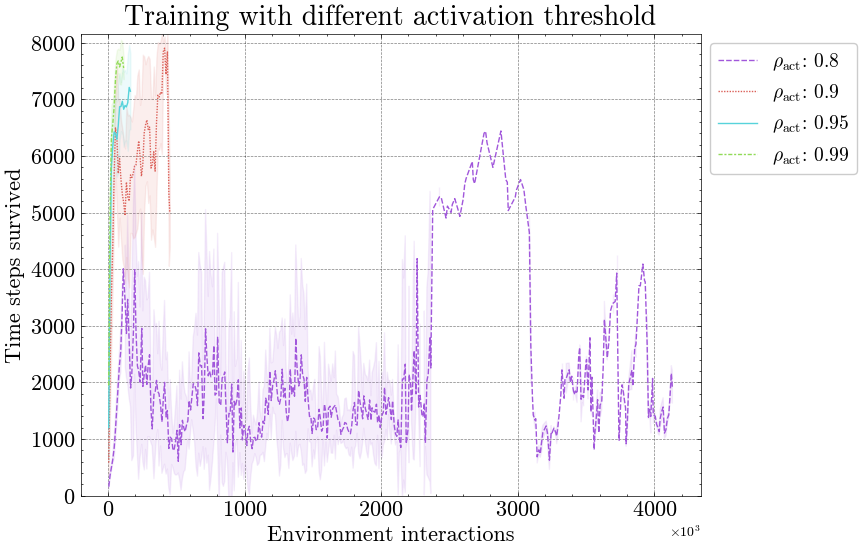

In [129]:
# plot 
plt = make_training_curve(df_at_long, 
                          header="Training with different activation threshold", 
                          palette=fixed_palette,
                          highvis=True,
                          order=order,
                          bin_width=10_000,
                         )
plt.savefig(os.path.join(path, f'Traincurve_ATLong.svg'))

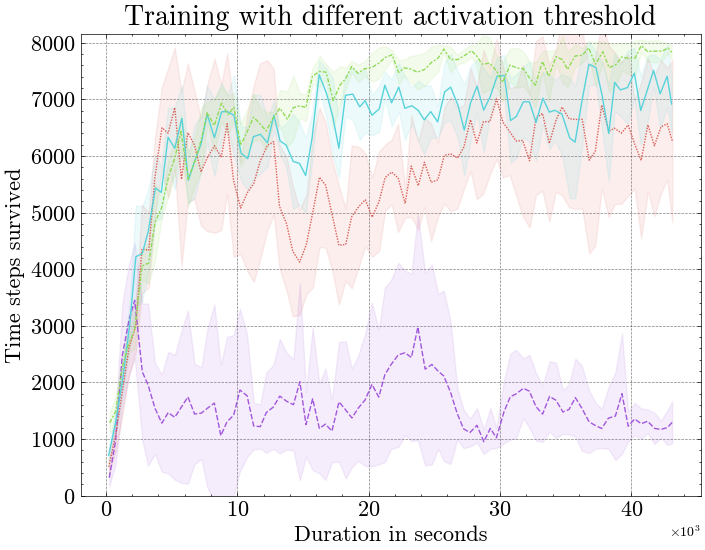

In [219]:
# plot 
plt = make_train_time_curve(df_at_long, 
                            header="Training with different activation threshold", 
                            palette=fixed_palette,
                            highvis=True,
                            order=order,
                            bin_width=500,
                           )
#plot without legend
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path, f'Traincurve_ATLong_time.svg'))

In [114]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_at_opp = make_df_metrics(runs_Opp)
df_at_opp

corrected_ep_len_mean  grid2op_end_std  mean_active_dn_count  \
0                       307     77137.614746              0.110619   
1                       300     99975.910671              0.135071   
2                       344     76784.846397              0.126728   
3                       391     86950.544056              0.149758   
4                       377    108779.984736              0.160287   
...                     ...              ...                   ...   
3855                    599    190388.367870              0.356948   
3856                    485    185311.475066              0.362205   
3857                    457    160753.354536              0.353107   
3858                    478    164089.601000              0.352113   
3859                    641    189584.420238              0.495549   

      mean_reconnect_count  grid2op_end_mean  mean_disconnect_count  \
0                 2.108407               307                      0   
1                 2.059242               300                      0   
2                 2.377880               344                      0   
3                 2.705314               391                      0   
4                 2.598086               377                      0   
...                    ...               ...                    ...   
3855              4.100817               599                      0   
3856              3.301837               485                      0   
3857              3.112994               457                      0   
3858              3.270423               478                      0   
3859              4.359050               641                      0   

      mean_interact_count  mean_reset_count  env_interactions  time_total_s  \
0                2.320796                 0              1049     50.278461   
1                2.457346                 0              2086    104.818601   
2                2.407834                 0              3131    164.240031   
3                2.533816                 0              4180    234.081394   
4                2.574163                 0              5256    307.710428   
...                   ...               ...               ...           ...   
3855             2.866485                 0            100323   8635.981668   
3856             2.797900                 0            101389   8735.359787   
3857             3.022599                 0            102459   8810.428698   
3858             2.904225                 0            103490   8888.379367   
3859             3.163205                 0            104556   8994.744732   

                           name  
0     $\rho_{\text{act}}$: 0.99  
1     $\rho_{\text{act}}$: 0.99  
2     $\rho_{\text{act}}$: 0.99  
3     $\rho_{\text{act}}$: 0.99  
4     $\rho_{\text{act}}$: 0.99  
...                         ...  
3855  $\rho_{\text{act}}$: 0.99  
3856  $\rho_{\text{act}}$: 0.99  
3857  $\rho_{\text{act}}$: 0.99  
3858  $\rho_{\text{act}}$: 0.99  
3859  $\rho_{\text{act}}$: 0.99  

[3860 rows x 11 columns]

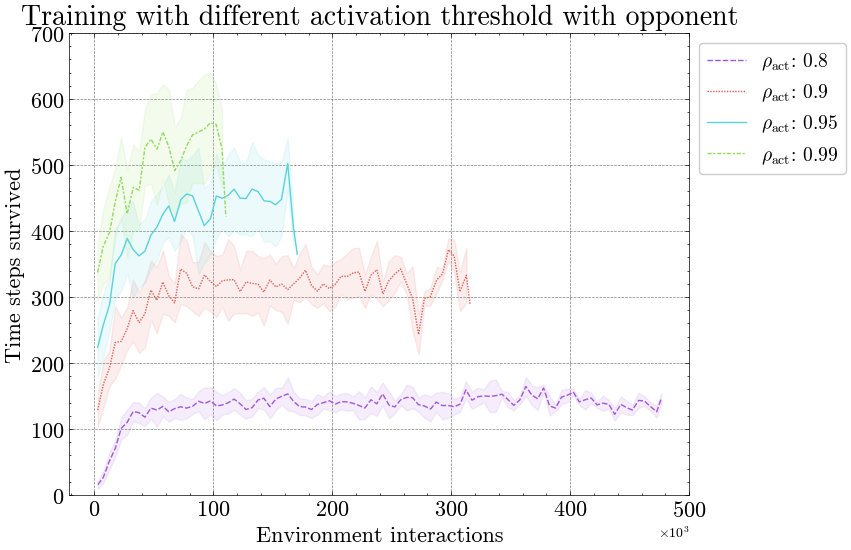

In [124]:
# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_training_curve(df_at_opp, 
                          header="Training with different activation threshold with opponent", 
                          palette=fixed_palette, 
                          highvis=True,
                          order=order,
                          max_env_steps=600,
                          bin_width=5000,
                         )
plt.savefig(os.path.join(path, f'Traincurve_ATLong_Opp.svg'))

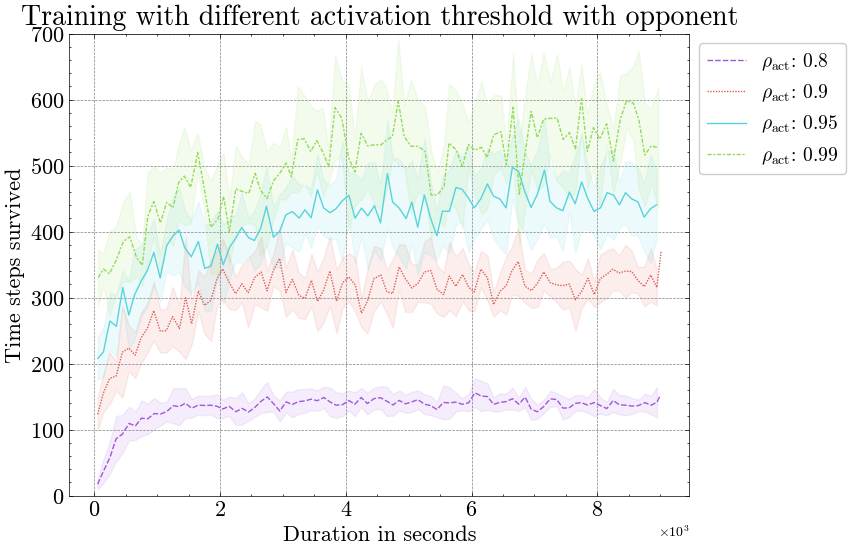

In [123]:
# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_train_time_curve(df_at_opp, 
                            header="Training with different activation threshold with opponent", 
                            palette=fixed_palette,
                            highvis=True,
                            order=order, 
                            max_env_steps=600,
                            bin_width=100,
                           )
plt.savefig(os.path.join(path, f'Traincurve_ATLong_Opp_time.svg'))

# Line switching experiments

In [178]:
project='Case14_SurveyPaperLine'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperLine
Matching runs: 40


In [179]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name 
        reco = str(True if run.config.get("env_config", {}).get("line_reco") is None else run.config.get("env_config", {}).get("line_reco"))
        disc = str(False if run.config.get("env_config", {}).get("line_disc") is None else run.config.get("env_config", {}).get("line_disc"))
        metrics_df['name'] = f"Reconnection: {reco}, Disconnection: {disc}"
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [180]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
print(f"Matching runs: {len(runs_NoOpp)}")

Matching runs: 15


In [181]:
df_line = make_df_metrics(runs_NoOpp)
df_line

mean_interact_count  grid2op_end_std  mean_reset_count  \
0                2.917614     4.892728e+04                 0   
1                2.972452     2.356962e+05                 0   
2                3.062500     3.257949e+05                 0   
3                3.559211     5.922907e+05                 0   
4                4.218750     1.357251e+06                 0   
...                   ...              ...               ...   
1373            12.510000     3.323386e+06                 0   
1374            11.142857     4.656186e+05                 0   
1375            13.070000     1.454713e+06                 0   
1376            11.920000     1.991036e+06                 0   
1377            21.100000     1.679826e+06                 0   

      mean_active_dn_count  grid2op_end_mean  mean_reconnect_count  \
0                 0.173295               614              0.000000   
1                 0.181818               590              0.013774   
2                 0.273810               804              0.000000   
3                 0.296053               800              0.000000   
4                 0.476562              1024              0.015625   
...                    ...               ...                   ...   
1373              5.980000              7321              0.000000   
1374              5.857143              7999              0.000000   
1375              8.000000              7691              0.000000   
1376              5.530000              7479              0.000000   
1377             15.030000              7503              0.000000   

      corrected_ep_len_mean  mean_disconnect_count  env_interactions  \
0                       614                    0.0              1027   
1                       590                    0.0              2106   
2                       804                    0.0              3135   
3                       800                    0.0              4217   
4                      1024                    0.0              5297   
...                     ...                    ...               ...   
1373                   7321                    0.0             93671   
1374                   7999                    0.0             94919   
1375                   7691                    0.0             96168   
1376                   7479                    0.0             97316   
1377                   7503                    0.0             99187   

                                           name  
0      Reconnection: True, Disconnection: False  
1      Reconnection: True, Disconnection: False  
2      Reconnection: True, Disconnection: False  
3      Reconnection: True, Disconnection: False  
4      Reconnection: True, Disconnection: False  
...                                         ...  
1373  Reconnection: False, Disconnection: False  
1374  Reconnection: False, Disconnection: False  
1375  Reconnection: False, Disconnection: False  
1376  Reconnection: False, Disconnection: False  
1377  Reconnection: False, Disconnection: False  

[1378 rows x 10 columns]

In [280]:
df_line.name.unique()

array(['Reconnection: True, Disconnection: False',
       'Reconnection: False, Disconnection: False',
       'Reconnection: True, Disconnection: True'], dtype=object)

In [290]:
sns.color_palette("hls", 3)

[(0.86, 0.3712, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.3712, 0.33999999999999997, 0.86)]

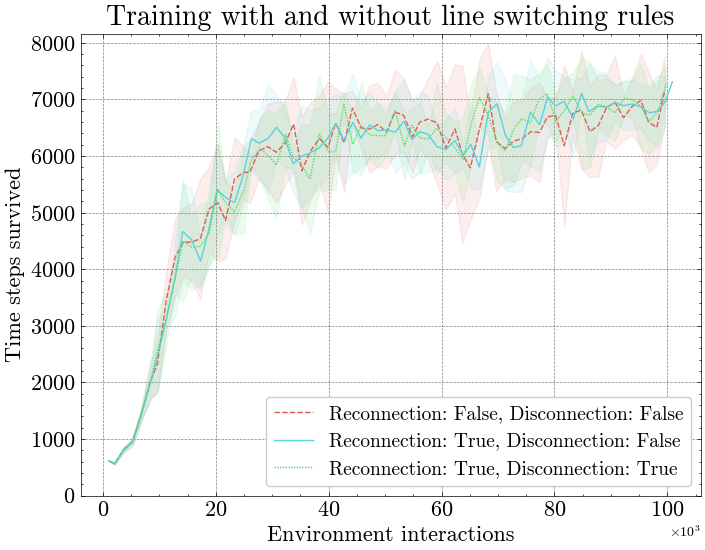

In [183]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_line['name'].unique()
baseline_name='Reconnection: True, Disconnection: False'
fixed_palette = make_color_dict(all_names, baseline_name=baseline_name)
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)

# plot 
plt = make_training_curve(df_line, 
                          header="Training with and without line switching rules", 
                          palette=fixed_palette,
                          highvis=True,
                          order=order
                         )
plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_Line.svg'))

In [184]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
print(f"Matching runs: {len(runs_Opp)}")

Matching runs: 15


In [185]:
df_line_opp = make_df_metrics(runs_Opp)
df_line_opp

grid2op_end_mean  mean_reset_count  mean_active_dn_count  \
0                  108                 0              0.000000   
1                  101                 0              0.000000   
2                  130                 0              0.000000   
3                  150                 0              0.000000   
4                  140                 0              0.000000   
...                ...               ...                   ...   
1385               342                 0              1.508772   
1386               382                 0              1.311005   
1387               461                 0              1.323944   
1388               489                 0              1.298507   
1389               507                 0              1.586592   

      mean_reconnect_count  corrected_ep_len_mean  mean_interact_count  \
0                 0.000000                    108             2.000000   
1                 0.000000                    101             2.000000   
2                 0.000000                    130             2.000000   
3                 0.000000                    150             2.000000   
4                 0.000000                    140             2.000000   
...                    ...                    ...                  ...   
1385              2.307018                    342             4.850877   
1386              2.550239                    382             5.172249   
1387              3.117371                    461             5.107981   
1388              3.194030                    489             5.104478   
1389              3.256983                    507             5.793296   

      mean_disconnect_count  grid2op_end_std  env_interactions  \
0                         0     12070.426687              1048   
1                         0     11076.104950              2145   
2                         0     14760.180753              3185   
3                         0     13848.133678              4224   
4                         0     13407.582540              5289   
...                     ...              ...               ...   
1385                      0    112260.412896             95683   
1386                      0    112864.741604             96764   
1387                      0    149080.428398             97852   
1388                      0    166429.633821             98878   
1389                      0    163954.581817             99915   

                                           name  
0     Reconnection: False, Disconnection: False  
1     Reconnection: False, Disconnection: False  
2     Reconnection: False, Disconnection: False  
3     Reconnection: False, Disconnection: False  
4     Reconnection: False, Disconnection: False  
...                                         ...  
1385   Reconnection: True, Disconnection: False  
1386   Reconnection: True, Disconnection: False  
1387   Reconnection: True, Disconnection: False  
1388   Reconnection: True, Disconnection: False  
1389   Reconnection: True, Disconnection: False  

[1390 rows x 10 columns]

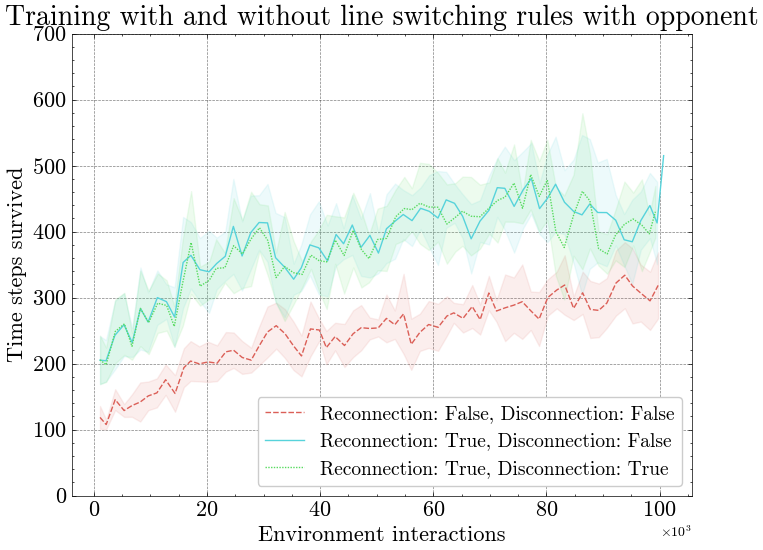

In [186]:
# plot 
plt = make_training_curve(df_line_opp, 
                          header="Training with and without line switching rules with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=600,
                          highvis=True,
                          order=order
                         )
plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_LineOpp.svg'))

# Revert Topo Experiments

In [187]:
project='Case14_SurveyPaperReset'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperReset
Matching runs: 55


In [191]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name
        rt = run.config.get("env_config", {}).get("reset_topo")
        reset_topo = "No RT" if rt==0 else ("$\\rho_{\\text{rev}}$: " + str(rt))
        metrics_df['name'] = reset_topo
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [192]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
print(f"Matching runs: {len(runs_NoOpp)}")

Matching runs: 20


In [193]:
df_rt = make_df_metrics(runs_NoOpp)
df_rt

mean_interact_count  grid2op_end_std  mean_reset_count  \
0                2.917614     4.892728e+04              0.00   
1                2.972452     2.356962e+05              0.00   
2                3.062500     3.257949e+05              0.00   
3                3.559211     5.922907e+05              0.00   
4                4.218750     1.357251e+06              0.00   
...                   ...              ...               ...   
1790            14.740000     3.523925e+06              2.47   
1791            14.200000     1.336741e+06              2.43   
1792            17.260000     1.019216e+06              3.37   
1793            20.550000     4.806808e+06              3.39   
1794            15.670000     6.302643e+06              1.91   

      mean_active_dn_count  grid2op_end_mean  mean_reconnect_count  \
0                 0.173295               614              0.000000   
1                 0.181818               590              0.013774   
2                 0.273810               804              0.000000   
3                 0.296053               800              0.000000   
4                 0.476562              1024              0.015625   
...                    ...               ...                   ...   
1790              9.540000              7199              0.040000   
1791              8.890000              7692              0.000000   
1792             10.680000              7687              0.040000   
1793             13.650000              6818              0.050000   
1794             10.440000              6250              0.010000   

      corrected_ep_len_mean  mean_disconnect_count  env_interactions  \
0                       614                      0              1027   
1                       590                      0              2106   
2                       804                      0              3135   
3                       800                      0              4217   
4                      1024                      0              5297   
...                     ...                    ...               ...   
1790                   7199                      0             94885   
1791                   7692                      0             96035   
1792                   7687                      0             97064   
1793                   6818                      0             98358   
1794                   6250                      0             99543   

                          name  
0                        No RT  
1                        No RT  
2                        No RT  
3                        No RT  
4                        No RT  
...                        ...  
1790  $\rho_{\text{rev}}$: 0.8  
1791  $\rho_{\text{rev}}$: 0.8  
1792  $\rho_{\text{rev}}$: 0.8  
1793  $\rho_{\text{rev}}$: 0.8  
1794  $\rho_{\text{rev}}$: 0.8  

[1795 rows x 10 columns]

In [194]:
df_rt['name'].unique()

array(['No RT', '$\\rho_{\\text{rev}}$: 0.95',
       '$\\rho_{\\text{rev}}$: 0.9', '$\\rho_{\\text{rev}}$: 0.8'],
      dtype=object)

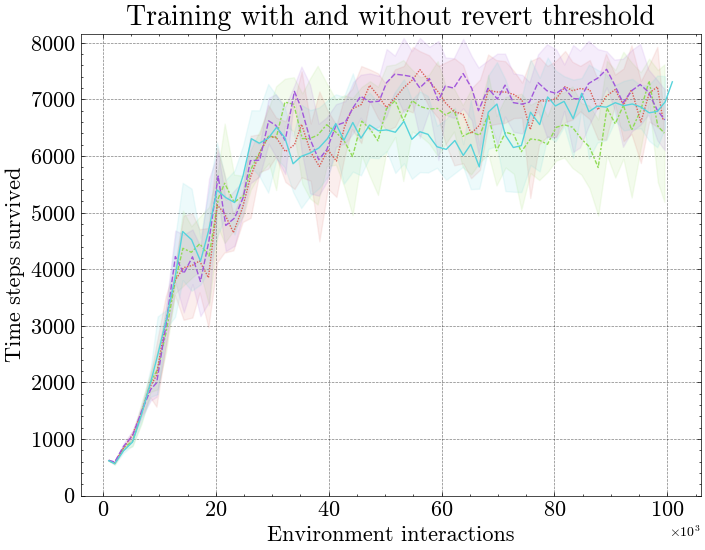

In [220]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_rt['name'].unique()
baseline_name='No RT'
fixed_palette = make_color_dict(all_names, baseline_name=baseline_name)
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)

# plot 
plt = make_training_curve(df_rt, 
                          header="Training with and without revert threshold", 
                          palette=fixed_palette,
                          highvis=True,
                          order=order,
                         )
#plot without legend
plt.legend([],[], frameon=False)
# plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_RT.svg'))

In [196]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
print(f"Matching runs: {len(runs_Opp)}")

Matching runs: 20


In [197]:
df_rt_opp = make_df_metrics(runs_Opp)
df_rt_opp

mean_reset_count  grid2op_end_mean  mean_disconnect_count  \
0                    0               170                      0   
1                    0               209                      0   
2                    0               244                      0   
3                    0               190                      0   
4                    0               253                      0   
...                ...               ...                    ...   
1856                 0               342                      0   
1857                 0               382                      0   
1858                 0               461                      0   
1859                 0               489                      0   
1860                 0               507                      0   

      mean_interact_count  corrected_ep_len_mean  mean_reconnect_count  \
0                2.000000                    170              1.000000   
1                3.000000                    209              1.000000   
2                2.000000                    244              1.000000   
3                2.000000                    190              1.000000   
4                3.000000                    253              1.000000   
...                   ...                    ...                   ...   
1856             4.850877                    342              2.307018   
1857             5.172249                    382              2.550239   
1858             5.107981                    461              3.117371   
1859             5.104478                    489              3.194030   
1860             5.793296                    507              3.256983   

      mean_active_dn_count  grid2op_end_std  env_interactions  \
0                 0.000000     38778.751446              1138   
1                 0.000000     46694.606617              2181   
2                 0.000000     71602.884760              3245   
3                 0.000000     49483.751954              4274   
4                 0.000000     59071.911208              5336   
...                    ...              ...               ...   
1856              1.508772    112260.412896             95683   
1857              1.311005    112864.741604             96764   
1858              1.323944    149080.428398             97852   
1859              1.298507    166429.633821             98878   
1860              1.586592    163954.581817             99915   

                          name  
0     $\rho_{\text{rev}}$: 0.8  
1     $\rho_{\text{rev}}$: 0.8  
2     $\rho_{\text{rev}}$: 0.8  
3     $\rho_{\text{rev}}$: 0.8  
4     $\rho_{\text{rev}}$: 0.8  
...                        ...  
1856                     No RT  
1857                     No RT  
1858                     No RT  
1859                     No RT  
1860                     No RT  

[1861 rows x 10 columns]

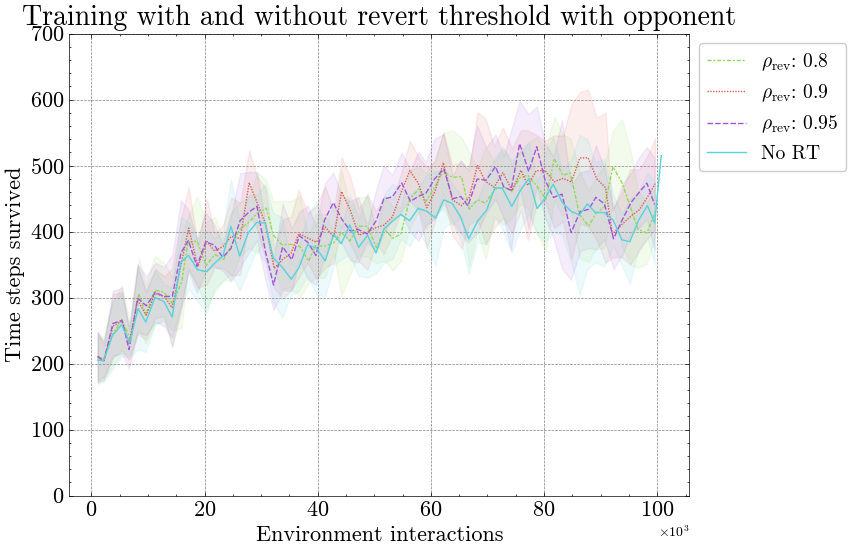

In [198]:
# plot 
plt = make_training_curve(df_rt_opp, 
                          header="Training with and without revert threshold with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=600,
                          highvis=True,
                          order=order
                         )
plt.savefig(os.path.join(path, f'Traincurve_RTOpp.svg'))

# Curriculum training

## RESULTS WITH BUG

In [364]:
project='Case14_SurveyPaperCurr'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperCurr
Matching runs: 45


In [365]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name
        curr = run.config.get("env_config", {}).get("curriculum_training", False)
        if curr:
            thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
            if thresholds == [20000,46667]:
                curriculum_training = "Curriculum"
            else:
                continue
        else:
            curriculum_training = "Baseline"
        metrics_df['name'] = curriculum_training        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [366]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_curr = make_df_metrics(runs_NoOpp)
df_curr

corrected_ep_len_mean  mean_reset_count  mean_reconnect_count  \
0                      722                 0              0.000000   
1                      613                 0              0.000000   
2                      634                 0              0.000000   
3                      854                 0              0.000000   
4                      773                 0              0.000000   
..                     ...               ...                   ...   
890                   7088                 0              0.000000   
891                   6997                 0              0.000000   
892                   6530                 0              0.004167   
893                   7481                 0              0.000000   
894                   6301                 0              0.000000   

     mean_disconnect_count  mean_active_dn_count  mean_interact_count  \
0                        0              0.678571             9.705357   
1                        0              0.570312             8.500000   
2                        0              0.714286             9.508929   
3                        0              0.920000            10.920000   
4                        0              1.165049            11.359223   
..                     ...                   ...                  ...   
890                      0              0.971154             5.096154   
891                      0              0.855769             4.971154   
892                      0              0.520833             4.395833   
893                      0              0.973214             4.816964   
894                      0              1.010417             5.614583   

     grid2op_end_std  grid2op_end_mean  env_interactions        name  
0       2.702314e+04               722              1087  Curriculum  
1       1.920387e+05               613              2175  Curriculum  
2       6.108609e+04               634              3240  Curriculum  
3       8.131415e+05               854              4293  Curriculum  
4       1.037136e+06               773              5463  Curriculum  
..               ...               ...               ...         ...  
890     4.151464e+06              7088             95453    Baseline  
891     2.996673e+06              6997             96487    Baseline  
892     4.910929e+06              6530             97542    Baseline  
893     2.332269e+06              7481             98621    Baseline  
894     5.586204e+06              6301             99699    Baseline  

[895 rows x 10 columns]

In [321]:
df_curr['name'].unique()

array(['No curriculum levels', 'Level 1: 20000, level 2: 46667'],
      dtype=object)

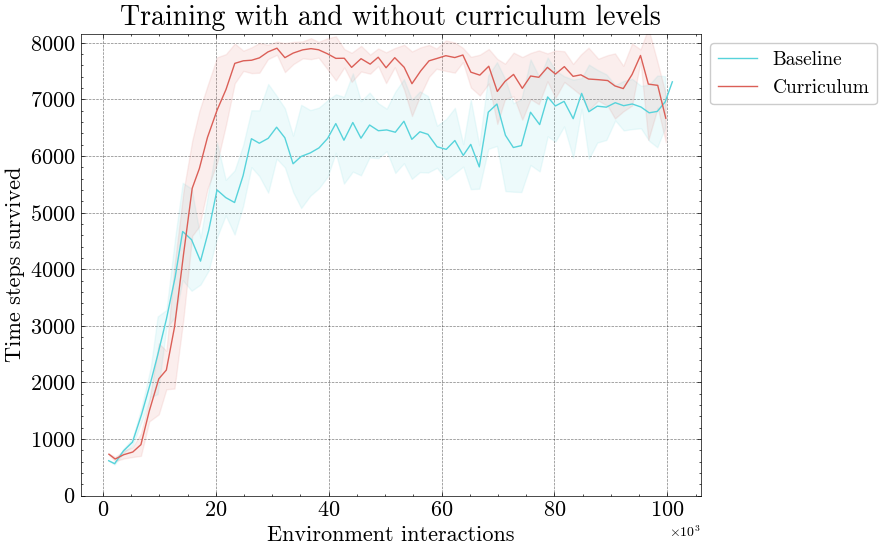

In [372]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_curr['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')

# plot 
plt = make_training_curve(df_curr, header="Training with and without curriculum levels", palette=fixed_palette)
# plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_Curr.svg'))

In [327]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_curr_opp = make_df_metrics(runs_Opp)
df_curr_opp

grid2op_end_mean  mean_reconnect_count  mean_reset_count  \
0                 206                  1.00                 0   
1                 177                  1.00                 0   
2                 227                  1.00                 0   
3                 331                  2.00                 0   
4                 284                  1.00                 0   
..                ...                   ...               ...   
869               551                  3.47                 0   
870               491                  3.14                 0   
871               551                  3.65                 0   
872               488                  3.27                 0   
873               556                  3.75                 0   

     mean_interact_count  corrected_ep_len_mean  grid2op_end_std  \
0                   2.00                    206     39305.914916   
1                   2.00                    177     41045.014405   
2                   3.00                    227     40382.894081   
3                   3.00                    331     56638.261145   
4                   3.00                    284     79204.594805   
..                   ...                    ...              ...   
869                19.71                    551    157432.257100   
870                17.33                    491    122832.537900   
871                17.71                    551    132499.406400   
872                19.74                    488     95220.301900   
873                18.06                    556    109903.107500   

     mean_active_dn_count  env_interactions        name  mean_disconnect_count  
0                    0.00              1115    Baseline                    NaN  
1                    0.00              2197    Baseline                    NaN  
2                    0.00              3281    Baseline                    NaN  
3                    0.00              4341    Baseline                    NaN  
4                    0.00              5381    Baseline                    NaN  
..                    ...               ...         ...                    ...  
869                  4.69             94607  Curriculum                    0.0  
870                  3.24             95705  Curriculum                    0.0  
871                  4.00             96986  Curriculum                    0.0  
872                  4.20             98082  Curriculum                    0.0  
873                  3.84             99271  Curriculum                    0.0  

[874 rows x 10 columns]

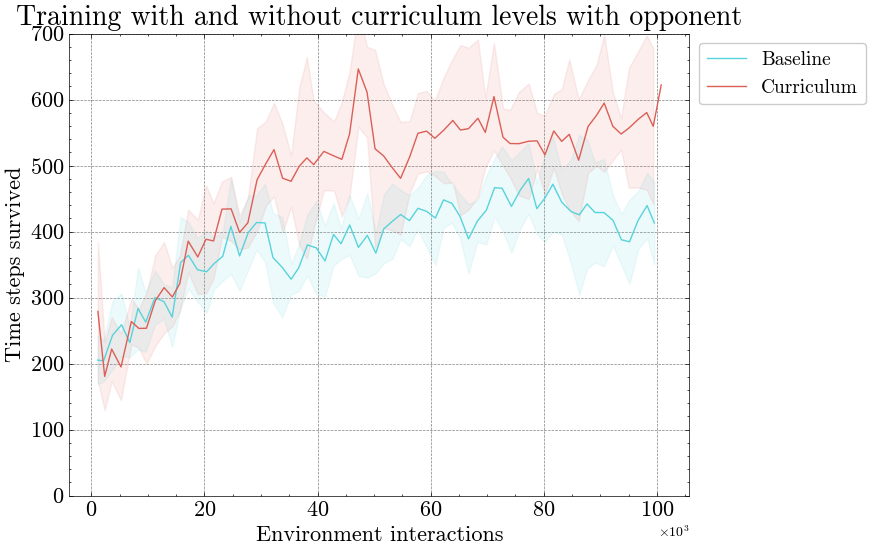

In [329]:
# Define all possible names and assign fixed colors
all_names = df_curr_opp['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')
# plot 
plt = make_training_curve(df_curr_opp, header="Training with and without curriculum levels with opponent", palette=fixed_palette, max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_CurrOpp.svg'))

In [317]:
agent_curr_levels = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    if run.config.get('num_sgd_iter')==15 and not run.config.get('opponent'):
        # Skip this agent -> wrong configuration.
        continue
    
    # Set name = curriculum training
    curr = run.config.get("env_config", {}).get("curriculum_training", False)
    if curr:
        thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
        curriculum_training = f"Level 1: {thresholds[0]}, level 2: {thresholds[1]}"
    else:
        curriculum_training = "No curriculum levels"
    data['curriculum training'] = curriculum_training     
    
    agent_curr_levels.append(data)

df_agent_curriculum = pd.DataFrame(agent_curr_levels)
df_agent_curriculum.to_csv(os.path.join(path, "curr_agent_ids.csv"), index=False)
df_agent_curriculum

agent_id             curriculum training
0   CustomPPO_old_env_9398580_7cbcd            No curriculum levels
1   CustomPPO_old_env_9398576_7a291            No curriculum levels
2   CustomPPO_old_env_9398578_766ba            No curriculum levels
3   CustomPPO_old_env_9398579_742a5            No curriculum levels
4   CustomPPO_old_env_9398577_75848            No curriculum levels
5   CustomPPO_old_env_9779113_241ce  Level 1: 30000, level 2: 60000
6   CustomPPO_old_env_9779114_26d44  Level 1: 30000, level 2: 60000
7   CustomPPO_old_env_9779112_25e7f  Level 1: 30000, level 2: 60000
8   CustomPPO_old_env_9779107_25f78  Level 1: 30000, level 2: 60000
9   CustomPPO_old_env_9779115_277c8  Level 1: 30000, level 2: 60000
10  CustomPPO_old_env_9786185_e75c8            No curriculum levels
11  CustomPPO_old_env_9786188_f216c            No curriculum levels
12  CustomPPO_old_env_9786187_f2790            No curriculum levels
13  CustomPPO_old_env_9786186_f2662            No curriculum levels
14  CustomPPO_old_env_9786184_f21f0            No curriculum levels
15  CustomPPO_old_env_9790378_99375  Level 1: 25000, level 2: 50000
16  CustomPPO_old_env_9790335_a1287  Level 1: 25000, level 2: 50000
17  CustomPPO_old_env_9790380_a139f  Level 1: 25000, level 2: 50000
18  CustomPPO_old_env_9790381_a1288  Level 1: 25000, level 2: 50000
19  CustomPPO_old_env_9790379_99d63  Level 1: 25000, level 2: 50000
20  CustomPPO_old_env_9790183_44ee6  Level 1: 25000, level 2: 50000
21  CustomPPO_old_env_9790172_40add  Level 1: 25000, level 2: 50000
22  CustomPPO_old_env_9790181_3fe06  Level 1: 25000, level 2: 50000
23  CustomPPO_old_env_9790184_44ee6  Level 1: 25000, level 2: 50000
24  CustomPPO_old_env_9790182_41e41  Level 1: 25000, level 2: 50000
25  CustomPPO_old_env_9796346_a7fee  Level 1: 20000, level 2: 46667
26  CustomPPO_old_env_9796347_a7ab3  Level 1: 20000, level 2: 46667
27  CustomPPO_old_env_9796349_a36fe  Level 1: 20000, level 2: 46667
28  CustomPPO_old_env_9796343_a2b4f  Level 1: 20000, level 2: 46667
29  CustomPPO_old_env_9796348_a34ef  Level 1: 20000, level 2: 46667
30  CustomPPO_old_env_9839609_cfaa1  Level 1: 20000, level 2: 46667
31  CustomPPO_old_env_9839610_cfafe  Level 1: 20000, level 2: 46667
32  CustomPPO_old_env_9839607_cb642  Level 1: 20000, level 2: 46667
33  CustomPPO_old_env_9839608_cb71b  Level 1: 20000, level 2: 46667
34  CustomPPO_old_env_9839606_cfc2a  Level 1: 20000, level 2: 46667

In [318]:
agent_curr_levels = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    if run.config.get('num_sgd_iter')==5 or run.config.get('opponent'):
        # Skip this agent -> correct configuration.
        continue
    
    # Set name = curriculum training
    curr = run.config.get("env_config", {}).get("curriculum_training", False)
    if curr:
        thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
        curriculum_training = f"Level 1: {thresholds[0]}, level 2: {thresholds[1]}"
    else:
        curriculum_training = "No curriculum levels"
    data['curriculum training'] = curriculum_training     
    
    agent_curr_levels.append(data)

df_agent_curriculum = pd.DataFrame(agent_curr_levels)
df_agent_curriculum.to_csv(os.path.join(path, "curr_agent_ids_WRONGPPO.csv"), index=False)
df_agent_curriculum

agent_id             curriculum training
0   CustomPPO_old_env_9779096_fc9e4  Level 1: 30000, level 2: 60000
1   CustomPPO_old_env_9779097_fc976  Level 1: 30000, level 2: 60000
2   CustomPPO_old_env_9779091_f3314  Level 1: 30000, level 2: 60000
3   CustomPPO_old_env_9779095_fc976  Level 1: 30000, level 2: 60000
4   CustomPPO_old_env_9779098_fc976  Level 1: 30000, level 2: 60000
5   CustomPPO_old_env_9791472_aab71  Level 1: 25000, level 2: 50000
6   CustomPPO_old_env_9791469_b68a9  Level 1: 25000, level 2: 50000
7   CustomPPO_old_env_9791473_b68f2  Level 1: 25000, level 2: 50000
8   CustomPPO_old_env_9791474_b68a9  Level 1: 25000, level 2: 50000
9   CustomPPO_old_env_9791471_aaba1  Level 1: 25000, level 2: 50000
10  CustomPPO_old_env_9839599_b19c3  Level 1: 20000, level 2: 46667
11  CustomPPO_old_env_9839600_adf5e  Level 1: 20000, level 2: 46667
12  CustomPPO_old_env_9839602_b2380  Level 1: 20000, level 2: 46667
13  CustomPPO_old_env_9839603_b19c3  Level 1: 20000, level 2: 46667
14  CustomPPO_old_env_9839601_b2380  Level 1: 20000, level 2: 46667

## UPDATE Curriculum Training after BUGFIX

In [199]:
project='Case14_SurveyPaperCurr1'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperCurr1
Matching runs: 25


In [200]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name
        curr = run.config.get("env_config", {}).get("curriculum_training", False)
        if curr:
            thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
            if thresholds == [20000,46667]:
                curriculum_training = "Curriculum"
            else:
                continue
        else:
            curriculum_training = "Baseline"
        metrics_df['name'] = curriculum_training        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [201]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_curr = make_df_metrics(runs_NoOpp)
df_curr

mean_interact_count  grid2op_end_std  mean_reset_count  \
0               2.917614     4.892728e+04                 0   
1               2.972452     2.356962e+05                 0   
2               3.062500     3.257949e+05                 0   
3               3.559211     5.922907e+05                 0   
4               4.218750     1.357251e+06                 0   
..                   ...              ...               ...   
904             3.764706     3.500225e+06                 0   
905             5.906250     2.049757e+06                 0   
906             4.901786     2.822627e+06                 0   
907             9.714286     7.868320e+06                 0   
908             4.859813     4.559429e+06                 0   

     mean_active_dn_count  grid2op_end_mean  mean_reconnect_count  \
0                0.173295               614              0.000000   
1                0.181818               590              0.013774   
2                0.273810               804              0.000000   
3                0.296053               800              0.000000   
4                0.476562              1024              0.015625   
..                    ...               ...                   ...   
904              0.628676              7504              0.000000   
905              1.781250              7384              0.000000   
906              1.419643              7576              0.004464   
907              3.500000              6019              0.000000   
908              1.037383              7325              0.004673   

     corrected_ep_len_mean  mean_disconnect_count  env_interactions  \
0                      614                      0              1027   
1                      590                      0              2106   
2                      804                      0              3135   
3                      800                      0              4217   
4                     1024                      0              5297   
..                     ...                    ...               ...   
904                   7504                      0             94628   
905                   7384                      0             95762   
906                   7576                      0             96860   
907                   6019                      0             97948   
908                   7325                      0             98988   

           name  
0      Baseline  
1      Baseline  
2      Baseline  
3      Baseline  
4      Baseline  
..          ...  
904  Curriculum  
905  Curriculum  
906  Curriculum  
907  Curriculum  
908  Curriculum  

[909 rows x 10 columns]

In [7]:
df_curr['name'].unique()

array(['Baseline', 'Curriculum'], dtype=object)

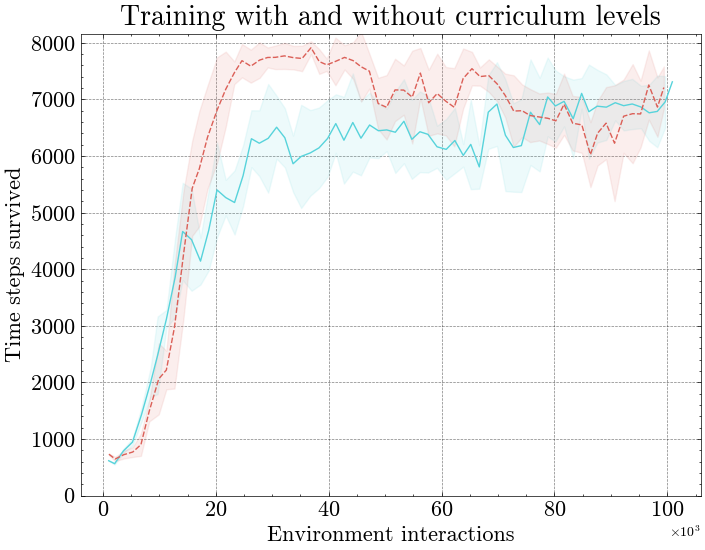

In [221]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_curr['name'].unique()
baseline_name='Baseline'
fixed_palette = make_color_dict(all_names, baseline_name=baseline_name)
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)

# plot 
plt = make_training_curve(df_curr, 
                          header="Training with and without curriculum levels", 
                          palette=fixed_palette,
                          highvis=True,
                          order=order,
                         )
#plot without legend
plt.legend([],[], frameon=False)
# plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_Curr.svg'))

In [203]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_curr_opp = make_df_metrics(runs_Opp)
df_curr_opp

mean_reset_count  grid2op_end_mean  mean_active_dn_count  \
0                   0               192              0.492537   
1                   0               155              0.690000   
2                   0               222              0.595588   
3                   0               181              0.730000   
4                   0               266              0.680000   
..                ...               ...                   ...   
895                 0               342              1.508772   
896                 0               382              1.311005   
897                 0               461              1.323944   
898                 0               489              1.298507   
899                 0               507              1.586592   

     mean_interact_count  grid2op_end_std  mean_disconnect_count  \
0               9.365672     35172.041713                      0   
1              11.700000     42483.053900                      0   
2               9.764706     46230.665009                      0   
3              11.790000     49068.213900                      0   
4              14.110000     64640.692400                      0   
..                   ...              ...                    ...   
895             4.850877    112260.412896                      0   
896             5.172249    112864.741604                      0   
897             5.107981    149080.428398                      0   
898             5.104478    166429.633821                      0   
899             5.793296    163954.581817                      0   

     mean_reconnect_count  corrected_ep_len_mean  env_interactions        name  
0                1.298507                    192              1255  Curriculum  
1                0.970000                    155              2343  Curriculum  
2                1.485294                    222              3671  Curriculum  
3                1.180000                    181              4710  Curriculum  
4                1.790000                    266              5960  Curriculum  
..                    ...                    ...               ...         ...  
895              2.307018                    342             95683    Baseline  
896              2.550239                    382             96764    Baseline  
897              3.117371                    461             97852    Baseline  
898              3.194030                    489             98878    Baseline  
899              3.256983                    507             99915    Baseline  

[900 rows x 10 columns]

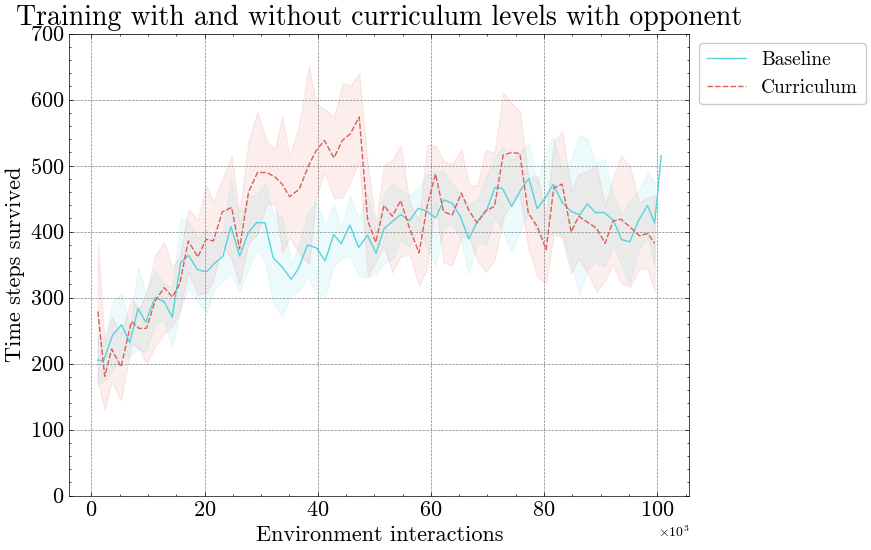

In [205]:
# plot 
plt = make_training_curve(df_curr_opp, 
                          header="Training with and without curriculum levels with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=600,
                          highvis=True,
                          order=order
                         )
plt.savefig(os.path.join(path, f'Traincurve_CurrOpp.svg'))

In [14]:
agent_curr_levels = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    if run.config.get('num_sgd_iter')==15 and not run.config.get('opponent'):
        # Skip this agent -> wrong configuration.
        continue
    
    # Set name = curriculum training
    curr = run.config.get("env_config", {}).get("curriculum_training", False)
    if curr:
        thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
        curriculum_training = f"Level 1: {thresholds[0]}, level 2: {thresholds[1]}"
    else:
        curriculum_training = "No curriculum levels"
    data['curriculum training'] = curriculum_training     
    
    agent_curr_levels.append(data)

df_agent_curriculum = pd.DataFrame(agent_curr_levels)
df_agent_curriculum.to_csv(os.path.join(path, "curr_agent_ids.csv"), index=False)
df_agent_curriculum

agent_id             curriculum training
0    CustomPPO_old_env_9398580_7cbcd            No curriculum levels
1    CustomPPO_old_env_9398576_7a291            No curriculum levels
2    CustomPPO_old_env_9398578_766ba            No curriculum levels
3    CustomPPO_old_env_9398579_742a5            No curriculum levels
4    CustomPPO_old_env_9398577_75848            No curriculum levels
5    CustomPPO_old_env_9786185_e75c8            No curriculum levels
6    CustomPPO_old_env_9786188_f216c            No curriculum levels
7    CustomPPO_old_env_9786187_f2790            No curriculum levels
8    CustomPPO_old_env_9786186_f2662            No curriculum levels
9    CustomPPO_old_env_9786184_f21f0            No curriculum levels
10  CustomPPO_old_env_10014510_1af50  Level 1: 20000, level 2: 46667
11  CustomPPO_old_env_10014514_27dca  Level 1: 20000, level 2: 46667
12  CustomPPO_old_env_10014512_27e1e  Level 1: 20000, level 2: 46667
13  CustomPPO_old_env_10014511_27dc9  Level 1: 20000, level 2: 46667
14  CustomPPO_old_env_10014522_aaf9d  Level 1: 20000, level 2: 46667
15  CustomPPO_old_env_10014513_27dc9  Level 1: 20000, level 2: 46667
16  CustomPPO_old_env_10014517_a87af  Level 1: 20000, level 2: 46667
17  CustomPPO_old_env_10014523_ab03f  Level 1: 20000, level 2: 46667
18  CustomPPO_old_env_10014520_a71b4  Level 1: 20000, level 2: 46667
19  CustomPPO_old_env_10014521_a7c91  Level 1: 20000, level 2: 46667

# Rainbow agent

## WITHOUT opponent

In [3]:
project='Case14_SurveyPaperRainbow'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperRainbow
Matching runs: 45


In [14]:
# Adjust function to include Rainbow with opponent information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df["agent_id"] = run.name    
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name

        # get action space:
        action_space = run.config.get("env_config", {}).get("action_space")
        # print(f"The action space of agent {run.name} is: {action_space}")

        # get observation space:
        if run.config.get("env_config", {}).get("g2op_input") == "all":
            obs_space = "Complete"   
        elif run.config.get("env_config", {}).get("g2op_input") == ["r"] or run.config.get("env_config", {}).get("g2op_input") == "r":
            obs_space = "Line loads"   
        elif run.config.get("env_config", {}).get("n_history") == 6:
            obs_space = "History" 
        elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
            obs_space = "Danger"
        elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "Baseline" 
        elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "D3QN_2022" 
        else:
            obs_space = ""
        
        # # print(f"The obs space of agent {run.name} is: {obs_space}")

        # get reward function:
        if run.config.get("reward_fun", "") == "ScaledL2RPNReward":
            rw_fun = "Baseline"   
        elif run.config.get("reward_fun", "") == "AlphaZeroRW":
            rw_fun = "AlphaZero" 
        elif run.config.get("reward_fun", "") == "RewardRho":
            rw_fun = "Binbinchen"
        elif run.config.get("reward_fun", "") == "LossReward":
            rw_fun = "SMAAC"
        elif run.config.get("reward_fun", "") == "ConstantReward":
            rw_fun = "Constant"            
        else:
            print("This reward function is not defined:", run.config.get("reward_fun", ""))
            rw_fun = ""

        rw_bonus = run.config.get("env_config", {}).get("reward_finish")
        
        # print(f"The rw_fun of agent {run.name} is: {rw_fun}")
        
        # get curriculum setting
        curr = run.config.get("env_config", {}).get("curriculum_training", False)
        
        # get activation threshold rho:
        rho_thr = run.config.get("env_config", {}).get("rho_threshold")

        # get disconnection rule:
        disc = False if run.config.get("env_config", {}).get("line_disc") is None else run.config.get("env_config", {}).get("line_disc")

        # get revert topology rule:
        rt = run.config.get("env_config", {}).get("reset_topo")

        if action_space=="medha" and obs_space=="Line loads" and rw_fun=="Baseline" and rw_bonus and curr and rho_thr==0.99 and disc and rt==0.9:
            metrics_df['name'] = "Rainbow"
        elif action_space=="medha" and obs_space=="Baseline" and rw_fun=="Baseline" and (not curr) and rho_thr==0.95 and (not disc) and rt==0 and (not rw_bonus):
            metrics_df['name'] = "Baseline"
        elif action_space=="tennet" and obs_space=="D3QN_2022" and rw_fun=="AlphaZero" and (not curr) and rho_thr==0.95 and (not disc) and rt==0 and (not rw_bonus):
            metrics_df['name'] = "Rainbow - Alternative"
        # elif action_space=="medha":
        #     metrics_df['name'] = "Rainbow - Act: $\mathcal{A}_{n-0}$"
        elif obs_space=="Baseline":
            metrics_df['name'] = "Rainbow - Obs: Baseline"
        # elif rw_fun=="Baseline":
        #     metrics_df['name'] = "Rainbow - RW: Baseline"
        elif not rw_bonus:
            metrics_df['name'] = "Rainbow - RW: Baseline"
        elif rho_thr==0.95:
            metrics_df['name'] = "Rainbow - $\\rho_{\\text{act}}=0.95$"
        elif not disc:
            metrics_df['name'] = "Rainbow - No disconnect"
        elif rt==0:
            metrics_df['name'] = "Rainbow - No RT"
        elif not curr:
            metrics_df['name'] = "Rainbow - No curriculum"
        else:
            metrics_df['name'] = "other"
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [15]:
df_rb = make_df_metrics(runs)
df_rb

mean_interact_count  grid2op_end_std  mean_reset_count  \
0                2.917614     4.892728e+04          0.000000   
1                2.972452     2.356962e+05          0.000000   
2                3.062500     3.257949e+05          0.000000   
3                3.559211     5.922907e+05          0.000000   
4                4.218750     1.357251e+06          0.000000   
...                   ...              ...               ...   
3969             6.198864     3.921446e+06          1.556818   
3970             7.393750     3.798264e+06          2.131250   
3971             6.568750     1.435182e+06          1.837500   
3972             5.697917     1.478151e+06          1.869792   
3973             4.812500     1.394356e+06          1.093750   

      mean_active_dn_count  grid2op_end_mean  mean_reconnect_count  \
0                 0.173295               614              0.000000   
1                 0.181818               590              0.013774   
2                 0.273810               804              0.000000   
3                 0.296053               800              0.000000   
4                 0.476562              1024              0.015625   
...                    ...               ...                   ...   
3969              1.812500              7221              0.068182   
3970              2.025000              7184              0.187500   
3971              2.037500              7532              0.125000   
3972              1.588542              7804              0.114583   
3973              1.558036              7697              0.169643   

      corrected_ep_len_mean  mean_disconnect_count  env_interactions  \
0                       614               0.000000              1027   
1                       590               0.000000              2106   
2                       804               0.000000              3135   
3                       800               0.000000              4217   
4                      1024               0.000000              5297   
...                     ...                    ...               ...   
3969                   7221               0.039773             95468   
3970                   7184               0.056250             96651   
3971                   7532               0.081250             97702   
3972                   7804               0.020833             98796   
3973                   7697               0.031250             99874   

                              agent_id                     name  
0      CustomPPO_old_env_9786185_e75c8                 Baseline  
1      CustomPPO_old_env_9786185_e75c8                 Baseline  
2      CustomPPO_old_env_9786185_e75c8                 Baseline  
3      CustomPPO_old_env_9786185_e75c8                 Baseline  
4      CustomPPO_old_env_9786185_e75c8                 Baseline  
...                                ...                      ...  
3969  CustomPPO_old_env_10558712_84eed  Rainbow - No curriculum  
3970  CustomPPO_old_env_10558712_84eed  Rainbow - No curriculum  
3971  CustomPPO_old_env_10558712_84eed  Rainbow - No curriculum  
3972  CustomPPO_old_env_10558712_84eed  Rainbow - No curriculum  
3973  CustomPPO_old_env_10558712_84eed  Rainbow - No curriculum  

[3974 rows x 11 columns]

In [10]:
sorted(df_rb.name.unique())

['Baseline',
 'Rainbow',
 'Rainbow - $\\rho_{\\textrm{act}}=0.95$',
 'Rainbow - Alternative',
 'Rainbow - No RT',
 'Rainbow - No curriculum',
 'Rainbow - No disconnect',
 'Rainbow - Obs: Baseline',
 'Rainbow - RW: Baseline']

In [11]:
df_rb.loc[(df_rb['name']=='Rainbow - No curriculum')].agent_id.unique()

array(['CustomPPO_old_env_10558710_87cd7',
       'CustomPPO_old_env_10558711_87cd7',
       'CustomPPO_old_env_10558713_8427c',
       'CustomPPO_old_env_10558709_84d1b',
       'CustomPPO_old_env_10558712_84eed'], dtype=object)

In [31]:
df_rb_plot = df_rb.loc[((df_rb['name']!='Rainbow - Alternative'))]

/var/folders/cf/czcpttnj1r3_8sqyc59jyr3r0000gn/T/ipykernel_10361/3695743723.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width


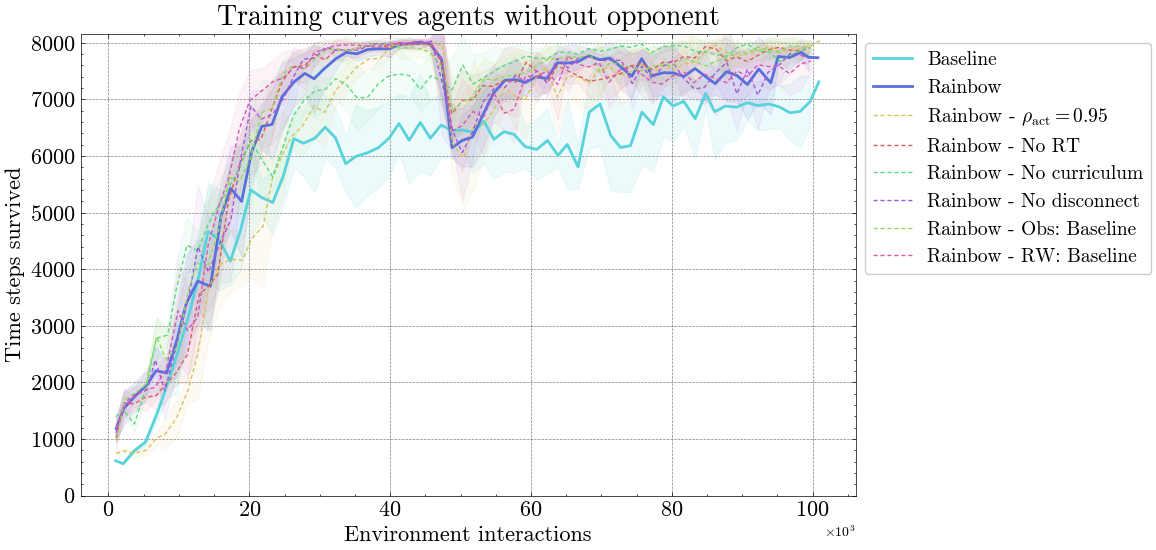

In [32]:
# Define all possible names and assign fixed colors
all_names = df_rb_plot['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')
# Use LateX notations.
plt.rcParams['text.usetex'] = True
# plot 
plt = make_training_curve(df_rb_plot, 
                          header="Training curves agents without opponent", 
                          palette=fixed_palette, 
                          # max_env_steps=900, 
                          # bin_width=5_000, 
                          fig_width=10, 
                          fig_height=6,
                          important_names=['Baseline','Rainbow'],
                          # highvis=True,
                         )
plt.savefig(os.path.join(path, f'Traincurve_Rainbow.svg'))

In [43]:
agent_curr_levels = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    # if run.config.get('num_sgd_iter')==15 and not run.config.get('opponent'):
    #     # Skip this agent -> wrong configuration.
    #     continue
    
    # Add data curriculum training
    curr = run.config.get("env_config", {}).get("curriculum_training", False)
    if curr:
        thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
        curriculum_training = f"Level 1: {thresholds[0]}, level 2: {thresholds[1]}"
    else:
        curriculum_training = "No curriculum levels"
    data['curriculum training'] = curriculum_training  
    # Add data reward bonus
    data['rw bonus'] = run.config.get("env_config", {}).get("reward_finish")
    
    agent_curr_levels.append(data)

df_agent_curriculum = pd.DataFrame(agent_curr_levels)
df_agent_curriculum.to_csv(os.path.join(path, "Rainbow_curr_agent_ids.csv"), index=False)
df_agent_curriculum

agent_id             curriculum training  rw bonus
0    CustomPPO_old_env_9786185_e75c8            No curriculum levels         0
1    CustomPPO_old_env_9786188_f216c            No curriculum levels         0
2    CustomPPO_old_env_9786187_f2790            No curriculum levels         0
3    CustomPPO_old_env_9786186_f2662            No curriculum levels         0
4    CustomPPO_old_env_9786184_f21f0            No curriculum levels         0
5   CustomPPO_old_env_10061796_575cf  Level 1: 20000, level 2: 46667       500
6   CustomPPO_old_env_10061798_594f9  Level 1: 20000, level 2: 46667       500
7   CustomPPO_old_env_10061795_55654  Level 1: 20000, level 2: 46667       500
8   CustomPPO_old_env_10061799_52ef9  Level 1: 20000, level 2: 46667       500
9   CustomPPO_old_env_10061797_5d398  Level 1: 20000, level 2: 46667       500
10  CustomPPO_old_env_10088050_3778d            No curriculum levels         0
11  CustomPPO_old_env_10088049_374fe            No curriculum levels         0
12  CustomPPO_old_env_10088048_373b8            No curriculum levels         0
13  CustomPPO_old_env_10088051_3a730            No curriculum levels         0
14  CustomPPO_old_env_10088047_3a532            No curriculum levels         0
15  CustomPPO_old_env_10088849_87d8f  Level 1: 20000, level 2: 46667       500
16  CustomPPO_old_env_10088833_ff5a1  Level 1: 20000, level 2: 46667         0
17  CustomPPO_old_env_10088830_0009d  Level 1: 20000, level 2: 46667         0
18  CustomPPO_old_env_10088860_a5a8f  Level 1: 20000, level 2: 46667       500
19  CustomPPO_old_env_10088844_5f3d4  Level 1: 20000, level 2: 46667       500
20  CustomPPO_old_env_10088846_6852a  Level 1: 20000, level 2: 46667       500
21  CustomPPO_old_env_10088831_fca4d  Level 1: 20000, level 2: 46667         0
22  CustomPPO_old_env_10088853_8a53b  Level 1: 20000, level 2: 46667       500
23  CustomPPO_old_env_10088845_5e7b1  Level 1: 20000, level 2: 46667       500
24  CustomPPO_old_env_10088858_a9828  Level 1: 20000, level 2: 46667       500
25  CustomPPO_old_env_10088856_a7969  Level 1: 20000, level 2: 46667       500
26  CustomPPO_old_env_10088859_a14d4  Level 1: 20000, level 2: 46667       500
27  CustomPPO_old_env_10088834_ff167  Level 1: 20000, level 2: 46667         0
28  CustomPPO_old_env_10088847_6852a  Level 1: 20000, level 2: 46667       500
29  CustomPPO_old_env_10088857_aa3f2  Level 1: 20000, level 2: 46667       500
30  CustomPPO_old_env_10088852_8aedc  Level 1: 20000, level 2: 46667       500
31  CustomPPO_old_env_10088832_07489  Level 1: 20000, level 2: 46667         0
32  CustomPPO_old_env_10088827_ba05c  Level 1: 20000, level 2: 46667       500
33  CustomPPO_old_env_10088825_ba75d  Level 1: 20000, level 2: 46667       500
34  CustomPPO_old_env_10088824_b3e9a  Level 1: 20000, level 2: 46667       500
35  CustomPPO_old_env_10088826_ba050  Level 1: 20000, level 2: 46667       500
36  CustomPPO_old_env_10088850_8332e  Level 1: 20000, level 2: 46667       500
37  CustomPPO_old_env_10088851_82baf  Level 1: 20000, level 2: 46667       500
38  CustomPPO_old_env_10088843_6852a  Level 1: 20000, level 2: 46667       500
39  CustomPPO_old_env_10088823_b9f75  Level 1: 20000, level 2: 46667       500
40  CustomPPO_old_env_10558710_87cd7            No curriculum levels       500
41  CustomPPO_old_env_10558711_87cd7            No curriculum levels       500
42  CustomPPO_old_env_10558713_8427c            No curriculum levels       500
43  CustomPPO_old_env_10558709_84d1b            No curriculum levels       500
44  CustomPPO_old_env_10558712_84eed            No curriculum levels       500

## Opponent results

In [18]:
project='Case14_SurveyPaperRainbow_Opp'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperRainbow_Opp
Matching runs: 65


In [25]:
# Adjust function to include Rainbow with opponent information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df["agent_id"] = run.name    
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name

        # get action space:
        action_space = run.config.get("env_config", {}).get("action_space")
        # print(f"The action space of agent {run.name} is: {action_space}")

        # get observation space:
        if run.config.get("env_config", {}).get("g2op_input") == "all":
            obs_space = "Complete"   
        elif run.config.get("env_config", {}).get("g2op_input") == ["r"] or run.config.get("env_config", {}).get("g2op_input") == "r":
            obs_space = "Line loads"   
        elif run.config.get("env_config", {}).get("n_history") == 6:
            obs_space = "History" 
        elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
            obs_space = "Danger"
        elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "Baseline" 
        elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "D3QN_2022" 
        else:
            obs_space = ""
        
        # # print(f"The obs space of agent {run.name} is: {obs_space}")

        # get reward function:
        if run.config.get("reward_fun", "") == "ScaledL2RPNReward":
            rw_fun = "Baseline"   
        elif run.config.get("reward_fun", "") == "AlphaZeroRW":
            rw_fun = "AlphaZero" 
        elif run.config.get("reward_fun", "") == "RewardRho":
            rw_fun = "Binbinchen"
        elif run.config.get("reward_fun", "") == "LossReward":
            rw_fun = "SMAAC"
        elif run.config.get("reward_fun", "") == "ConstantReward":
            rw_fun = "Constant"            
        else:
            print("This reward function is not defined:", run.config.get("reward_fun", ""))
            rw_fun = ""

        rw_bonus = run.config.get("env_config", {}).get("reward_finish")
        
        # print(f"The rw_fun of agent {run.name} is: {rw_fun}")
        
        # get curriculum setting
        curr = run.config.get("env_config", {}).get("curriculum_training", False)
        
        # get activation threshold rho:
        rho_thr = run.config.get("env_config", {}).get("rho_threshold")

        # get disconnection rule:
        disc = False if run.config.get("env_config", {}).get("line_disc") is None else run.config.get("env_config", {}).get("line_disc")

        # get revert topology rule:
        rt = run.config.get("env_config", {}).get("reset_topo")

        if action_space=="d3qn2022" and obs_space=="Baseline" and rw_fun=="AlphaZero" and (not curr) and rho_thr==0.99 and disc and rt==0.8 and (not rw_bonus):
            metrics_df['name'] = "Rainbow"
        elif action_space=="medha" and obs_space=="Baseline" and rw_fun=="Baseline" and (not curr) and rho_thr==0.95 and (not disc) and rt==0 and (not rw_bonus):
            metrics_df['name'] = "Baseline"
        elif action_space=="d3qn2022" and obs_space=="Line loads" and rw_fun=="Baseline" and curr and rho_thr==0.99 and disc and rt==0.9 and rw_bonus:
            metrics_df['name'] = "Rainbow PPO - Act: $\mathcal{A}_{d3qn}$"
        elif action_space=="medha" and curr:
            metrics_df['name'] = "Rainbow PPO"
        elif action_space=="medha":
            metrics_df['name'] = "Rainbow - Act: $\mathcal{A}_{n-0}$"
        # elif obs_space=="Baseline":
        #     metrics_df['name'] = "Rainbow - obs: Baseline"
        elif rw_fun=="Baseline":
            metrics_df['name'] = "Rainbow - RW: Baseline"
        elif rho_thr==0.95:
            metrics_df['name'] = "Rainbow - $\\rho_{\\text{act}}=0.95$"
        elif not disc:
            metrics_df['name'] = "Rainbow - No disconnect"
        elif rt==0:
            metrics_df['name'] = "Rainbow - No RT"
        elif curr:
            if rw_bonus:
                metrics_df['name'] = "Rainbow + Curriculum + Bonus/Penalty"
            else:
                metrics_df['name'] = "Rainbow + Curriculum"
        elif rw_fun=="Binbinchen":
            metrics_df['name'] = "Rainbow - RW: Binbinchen"
        elif rw_bonus:
            metrics_df['name'] = "Rainbow + Bonus/Penalty"
        else:
            metrics_df['name'] = "other"
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [26]:
# filtered_runs = [run for run in runs if not run.config.get("env_config", {}).get("curriculum_training", False)]
df_rb_opp = make_df_metrics(runs)
df_rb_opp

mean_active_dn_count  grid2op_end_mean  mean_reset_count  \
0                 42.875000               877          0.812500   
1                 38.062500              1090          0.937500   
2                 42.625000              1345          1.225000   
3                 54.520833              1650          1.479167   
4                 64.030000              1953          1.830000   
...                     ...               ...               ...   
27033              0.309677               487          0.496774   
27034              0.209790               578          0.580420   
27035              0.207921               660          0.712871   
27036              0.172131               626          0.819672   
27037              0.253012               608          0.602410   

       mean_disconnect_count  corrected_ep_len_mean  grid2op_end_std  \
0                   1.562500                    877     3.127632e+05   
1                   1.500000                   1090     4.646543e+05   
2                   1.662500                   1345     1.297787e+06   
3                   1.854167                   1650     2.628051e+06   
4                   2.250000                   1953     3.402860e+06   
...                      ...                    ...              ...   
27033               0.006452                    487     2.362964e+05   
27034               0.006993                    578     4.638703e+05   
27035               0.009901                    660     4.149228e+05   
27036               0.016393                    626     2.870811e+05   
27037               0.012048                    608     2.825461e+05   

       mean_reconnect_count  mean_interact_count  env_interactions  \
0                  5.218750           118.031250              3777   
1                  6.812500            96.296875              6163   
2                  8.475000           106.700000              8536   
3                 10.385417           137.572917             13207   
4                 12.400000           158.400000             17151   
...                     ...                  ...               ...   
27033              3.270968             7.329032            495125   
27034              3.874126             7.895105            496254   
27035              4.386139            10.752475            497340   
27036              4.147541             8.696721            498401   
27037              4.096386             7.246988            499604   

                               agent_id                                  name  
0      CustomPPO_old_env_10061852_42d58  Rainbow + Curriculum + Bonus/Penalty  
1      CustomPPO_old_env_10061852_42d58  Rainbow + Curriculum + Bonus/Penalty  
2      CustomPPO_old_env_10061852_42d58  Rainbow + Curriculum + Bonus/Penalty  
3      CustomPPO_old_env_10061852_42d58  Rainbow + Curriculum + Bonus/Penalty  
4      CustomPPO_old_env_10061852_42d58  Rainbow + Curriculum + Bonus/Penalty  
...                                 ...                                   ...  
27033  CustomPPO_old_env_10667739_483f2                           Rainbow PPO  
27034  CustomPPO_old_env_10667739_483f2                           Rainbow PPO  
27035  CustomPPO_old_env_10667739_483f2                           Rainbow PPO  
27036  CustomPPO_old_env_10667739_483f2                           Rainbow PPO  
27037  CustomPPO_old_env_10667739_483f2                           Rainbow PPO  

[27038 rows x 11 columns]

In [27]:
sorted(df_rb_opp.name.unique())

['Baseline',
 'Rainbow',
 'Rainbow + Bonus/Penalty',
 'Rainbow + Curriculum',
 'Rainbow + Curriculum + Bonus/Penalty',
 'Rainbow - $\\rho_{\\text{act}}=0.95$',
 'Rainbow - Act: $\\mathcal{A}_{n-0}$',
 'Rainbow - No RT',
 'Rainbow - No disconnect',
 'Rainbow - RW: Baseline',
 'Rainbow - RW: Binbinchen',
 'Rainbow PPO',
 'Rainbow PPO - Act: $\\mathcal{A}_{d3qn}$']

In [22]:
df_rb_opp.loc[(df_rb_opp['name']=='Rainbow PPO - Act: $\\mathcal{A}_{d3qn}$')].agent_id.unique()

array(['CustomPPO_old_env_10088786_339fb',
       'CustomPPO_old_env_10088782_33783',
       'CustomPPO_old_env_10088783_2ebbf',
       'CustomPPO_old_env_10088785_378db',
       'CustomPPO_old_env_10088784_2d9aa'], dtype=object)

In [28]:
df_rb_opp_alt = df_rb_opp.loc[((df_rb_opp['name']=='Rainbow - RW: Binbinchen') | 
                            (df_rb_opp['name']=='Rainbow + Bonus/Penalty') |
                            (df_rb_opp['name']=='Rainbow PPO - Act: $\\mathcal{A}_{d3qn}$') |
                            (df_rb_opp['name']=='Rainbow PPO') |
                            (df_rb_opp['name']=='Rainbow + Curriculum + Bonus/Penalty') |
                            (df_rb_opp['name']=='Rainbow + Curriculum')
                           )]
df_rb_plot = df_rb_opp.loc[((df_rb_opp['name']!='Rainbow - RW: Binbinchen') & 
                            (df_rb_opp['name']!='Rainbow + Bonus/Penalty') &
                            (df_rb_opp['name']!='Rainbow PPO - Act: $\\mathcal{A}_{d3qn}$') &
                            (df_rb_opp['name']!='Rainbow PPO') &
                            (df_rb_opp['name']!='Rainbow + Curriculum + Bonus/Penalty') &
                            (df_rb_opp['name']!='Rainbow + Curriculum')
                           )]

/var/folders/cf/czcpttnj1r3_8sqyc59jyr3r0000gn/T/ipykernel_10361/3695743723.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width


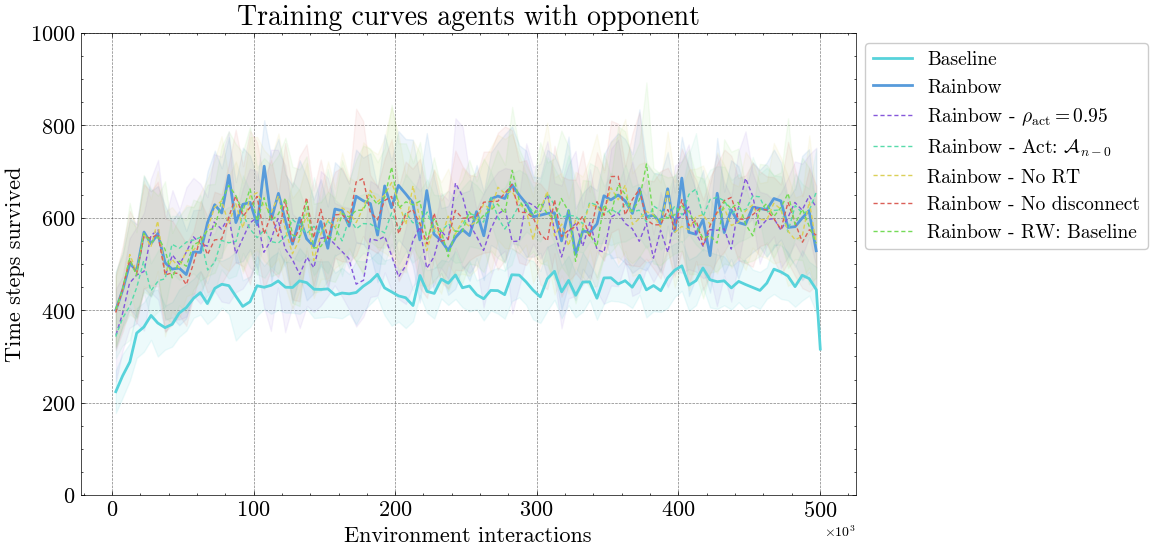

In [30]:
# Define all possible names and assign fixed colors
all_names = df_rb_plot['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')
# Use LateX notations.
plt.rcParams['text.usetex'] = True
# plot 
plt = make_training_curve(df_rb_plot, 
                          header="Training curves agents with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=900, 
                          bin_width=5_000, 
                          fig_width=10, 
                          fig_height=6,
                          important_names=['Baseline','Rainbow'],
                          # highvis=True,
                         )
plt.savefig(os.path.join(path, f'Traincurve_RainbowOpp.svg'))

In [45]:
agent_curr_levels = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    if run.config.get('num_sgd_iter')==15 and not run.config.get('opponent'):
        # Skip this agent -> wrong configuration.
        continue
    
    # Set name = curriculum training
    curr = run.config.get("env_config", {}).get("curriculum_training", False)
    if curr:
        thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
        curriculum_training = f"Level 1: {thresholds[0]}, level 2: {thresholds[1]}"
    else:
        curriculum_training = "No curriculum levels"
    data['curriculum training'] = curriculum_training   

    data['rw bonus'] = run.config.get("env_config", {}).get("reward_finish")
    
    agent_curr_levels.append(data)

df_agent_curriculum = pd.DataFrame(agent_curr_levels)
df_agent_curriculum.to_csv(os.path.join(path, "RainbowOpp_curr_agent_ids.csv"), index=False)
df_agent_curriculum

agent_id               curriculum training  \
0   CustomPPO_old_env_10061852_42d58  Level 1: 100000, level 2: 233333   
1   CustomPPO_old_env_10061851_3dc84  Level 1: 100000, level 2: 233333   
2   CustomPPO_old_env_10061848_177b1              No curriculum levels   
3   CustomPPO_old_env_10061847_159c9              No curriculum levels   
4   CustomPPO_old_env_10061839_ccee2              No curriculum levels   
..                               ...                               ...   
60  CustomPPO_old_env_10667735_3c012  Level 1: 100000, level 2: 233333   
61  CustomPPO_old_env_10667736_484e2  Level 1: 100000, level 2: 233333   
62  CustomPPO_old_env_10667738_484d6  Level 1: 100000, level 2: 233333   
63  CustomPPO_old_env_10667737_483f2  Level 1: 100000, level 2: 233333   
64  CustomPPO_old_env_10667739_483f2  Level 1: 100000, level 2: 233333   

    rw bonus  
0        500  
1        500  
2        500  
3        500  
4        500  
..       ...  
60       500  
61       500  
62       500  
63       500  
64       500  

[65 rows x 3 columns]

/var/folders/cf/czcpttnj1r3_8sqyc59jyr3r0000gn/T/ipykernel_10361/550708966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width


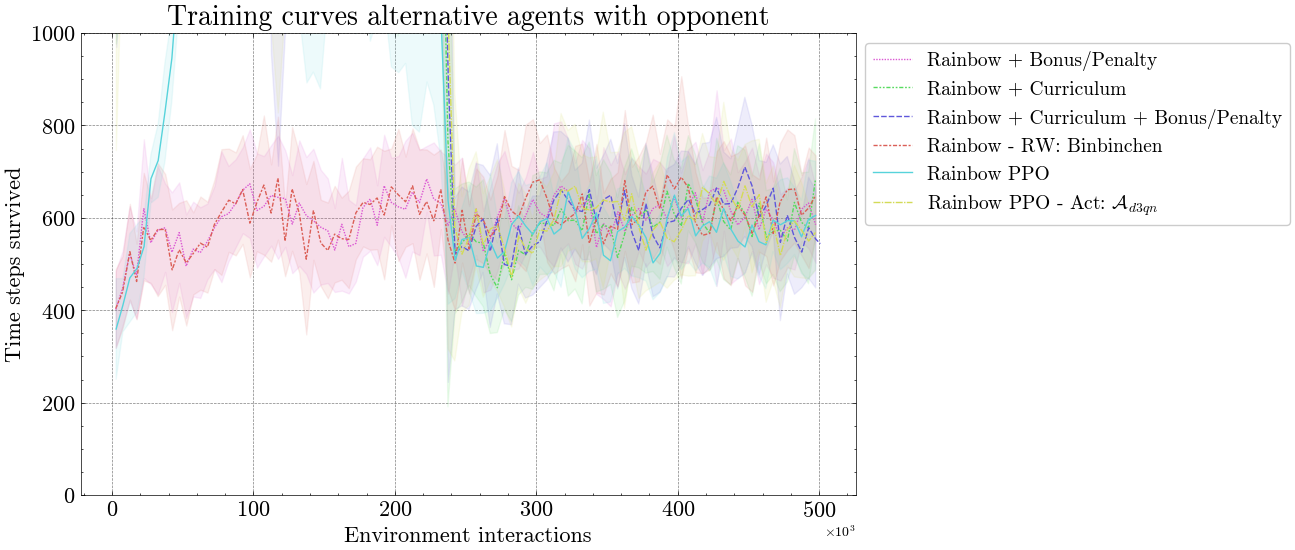

In [100]:
# Define all possible names and assign fixed colors
all_names = df_rb_opp_alt['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Rainbow PPO')
baseline_name='Rainbow PPO'
pos = np.nonzero(all_names==baseline_name)[0][0]
order=np.roll(all_names, -pos)
# Use LateX notations.
plt.rcParams['text.usetex'] = True
# plot 
plt = make_training_curve(df_rb_opp_alt, 
                          header="Training curves alternative agents with opponent", 
                          palette=fixed_palette, 
                          max_env_steps=900, 
                          bin_width=5_000, 
                          fig_width=10, 
                          fig_height=6,
                          # important_names=['Baseline','Rainbow'],
                          highvis=True,
                          order=order,
                         )
plt.savefig(os.path.join(path, f'Traincurve_RainbowOppAlt.svg'))